In [581]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as GridSpec
import warnings

from itertools import combinations
from collections import Counter


from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler


from functions import *

from scipy.stats import skew
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

#!pip install minisom --upgrade
from minisom import MiniSom
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import eig

## Load Data

In [561]:
# Importing the dataset
df = pd.read_csv('Case1_HotelCustomerSegmentation_Preprocessed.csv', sep=',')
#df.set_index('ID', inplace=True)

In [562]:
df.columns

Index(['ID', 'Nationality', 'DistributionChannel', 'MarketSegment',
       'SRAccessibleRoom', 'SRCrib', 'SRNoAlcoholInMiniBar', 'SRQuietRoom',
       'PersonRoomRatio', 'BookingConversionRate', 'Continent',
       'AccompanyingGuest', 'MultipleRooms', 'AgeGroup', 'LeadTimeSegment',
       'FloorAsked', 'BathAsked', 'BedAsked', 'DistanceElevatorAsked',
       'OtherRevenue_log', 'TotalRevenue_log', 'SpendingPerPerson_log',
       'PersonsNights_log', 'AvgPersonsPerBooking_log', 'SpendingTier'],
      dtype='object')

## Booking behavior Perspective

In [565]:
behav_cols = ['PersonRoomRatio', 'AvgPersonsPerBooking_log', 'BookingConversionRate']

In [566]:
df[behav_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
PersonRoomRatio,69720.0,-0.013461,9.426001e-01,-1.417752,0.084564,0.084564,0.084564,3.089197
AvgPersonsPerBooking_log,69720.0,-0.022399,9.224853e-01,-1.942047,-0.728718,0.250868,0.690785,1.804060
BookingConversionRate,69720.0,0.039245,6.938944e-18,0.039245,0.039245,0.039245,0.039245,0.039245


In [567]:
missing_data(df[behav_cols])

,Missing Count,Missing %


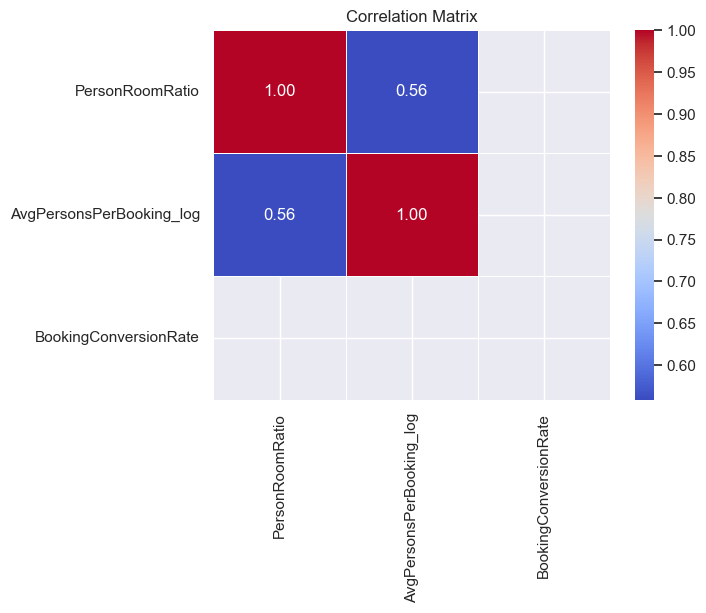

In [568]:

sns.heatmap(df[behav_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


# KMeans Clustering 

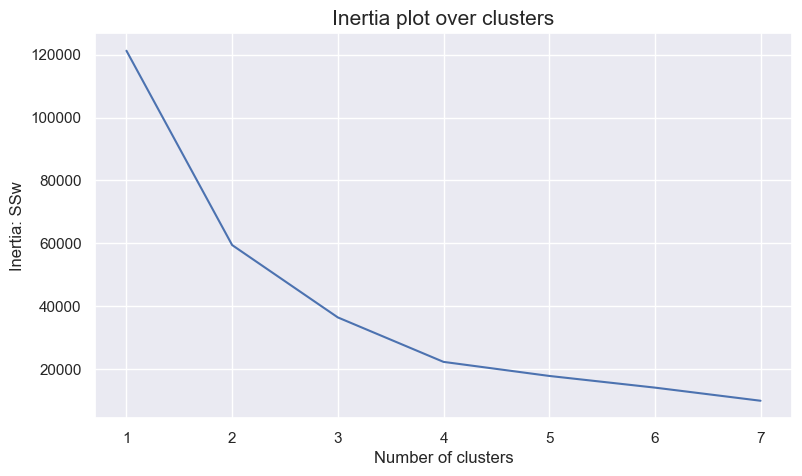

In [569]:

range_clusters = range(1, 8)
inertia = []
for n_clus in range_clusters:  
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=42)
    kmclust.fit(df[behav_cols])
    inertia.append(kmclust.inertia_)
    
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(range_clusters, inertia)
ax.set_xticks(range_clusters)
ax.set_ylabel("Inertia: SSw")
ax.set_xlabel("Number of clusters")
ax.set_title("Inertia plot over clusters", size=15)
plt.show()


For n_clusters = 2, the average silhouette_score is : 0.569893871857903
For n_clusters = 3, the average silhouette_score is : 0.6189396072030812
For n_clusters = 4, the average silhouette_score is : 0.6273005889478717
For n_clusters = 5, the average silhouette_score is : 0.6279014166543574
For n_clusters = 6, the average silhouette_score is : 0.6073615384690632
For n_clusters = 7, the average silhouette_score is : 0.6557493042512283


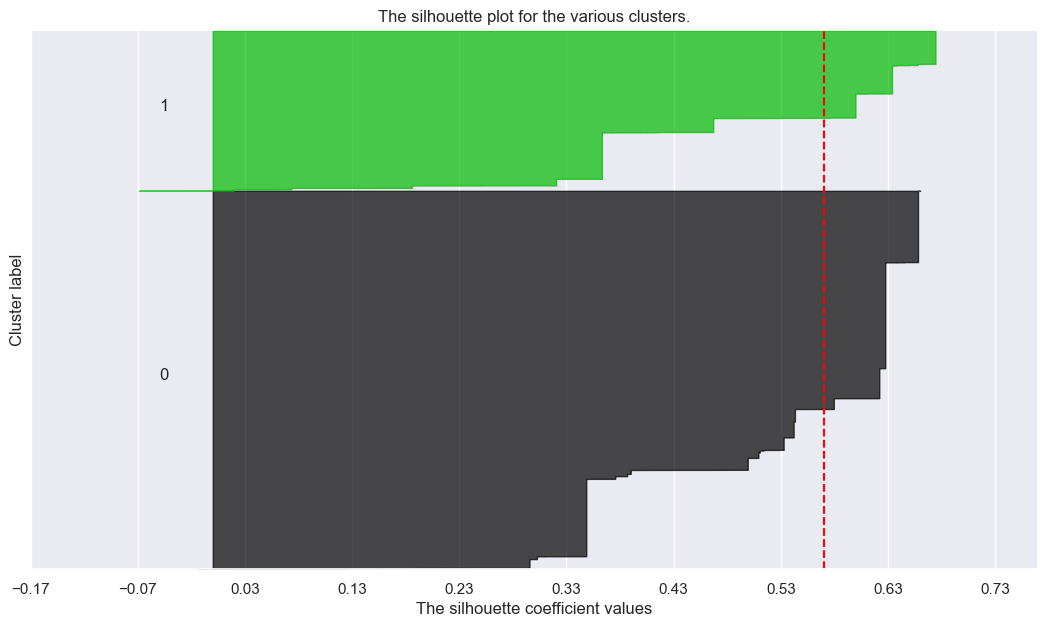

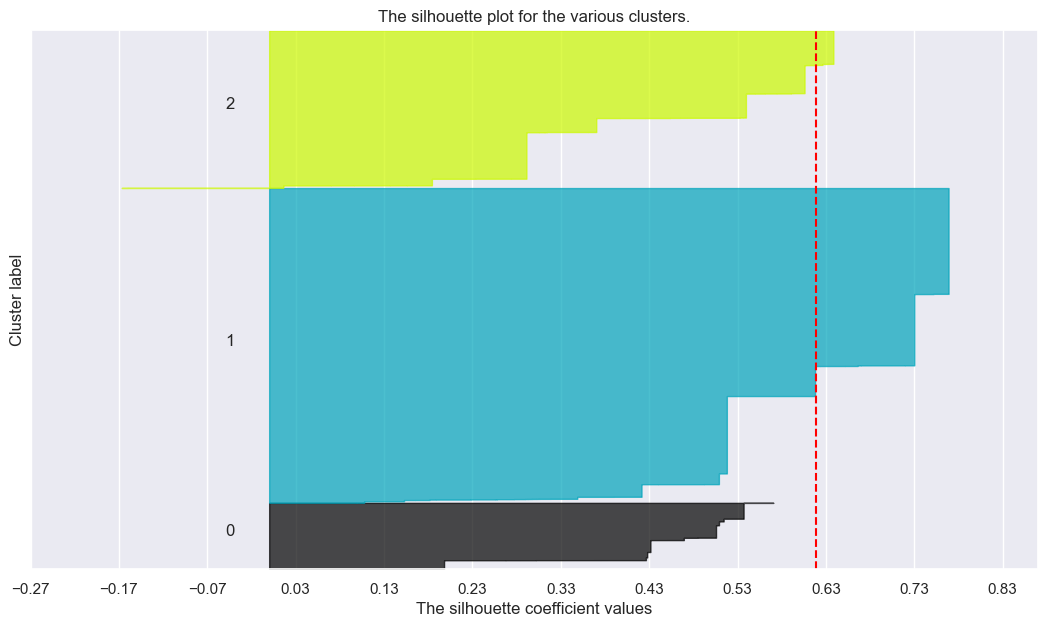

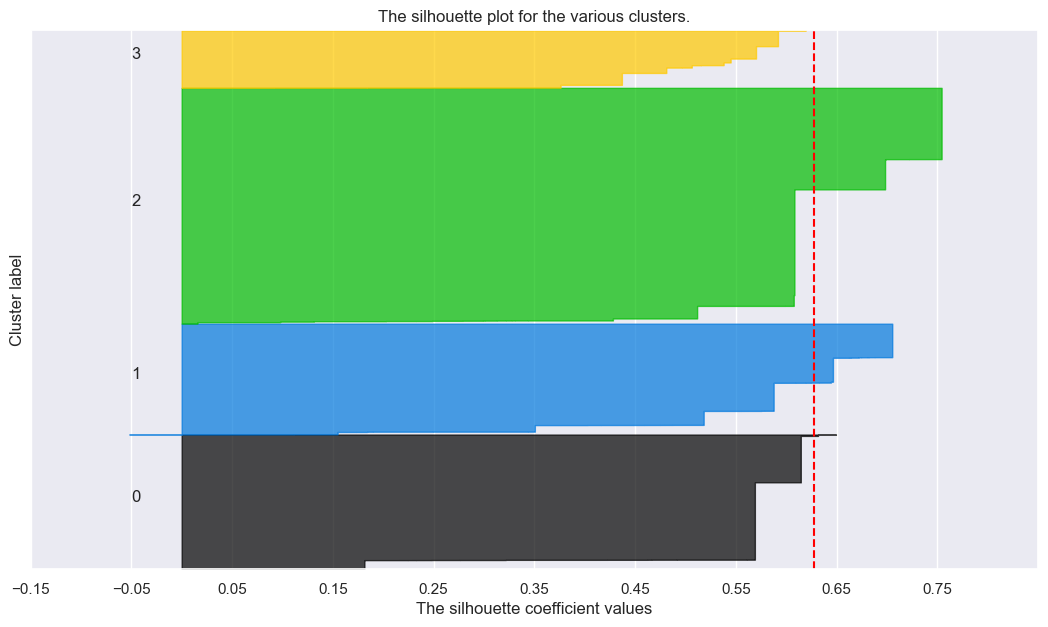

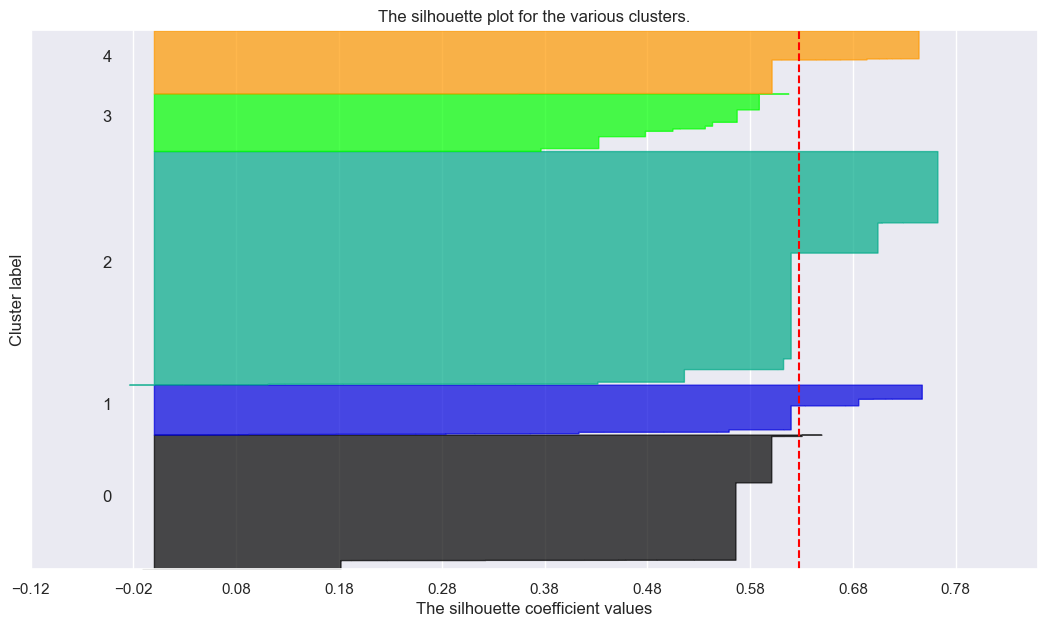

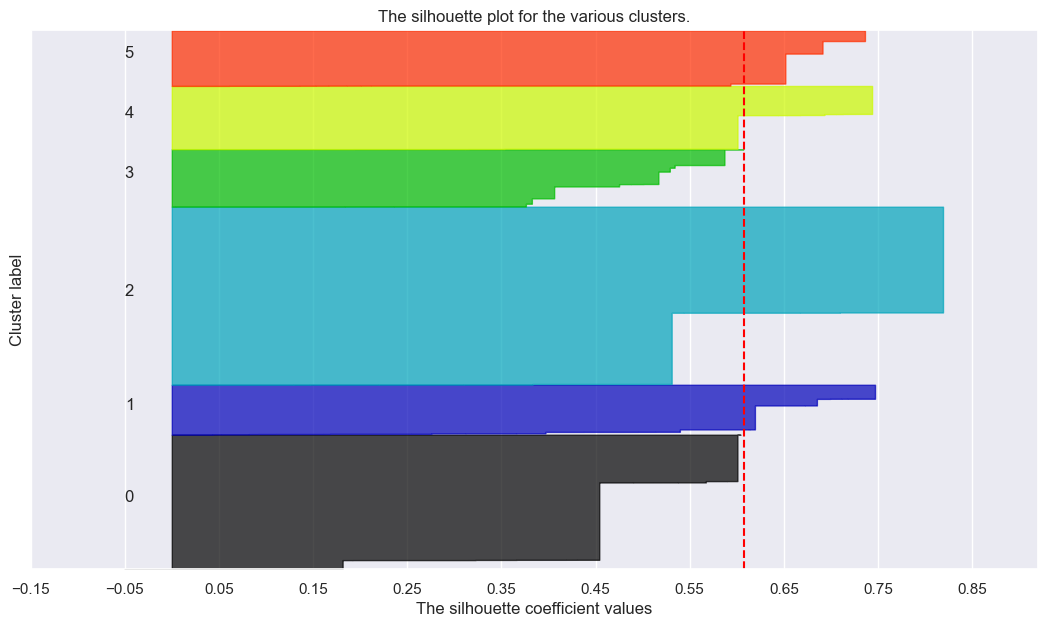

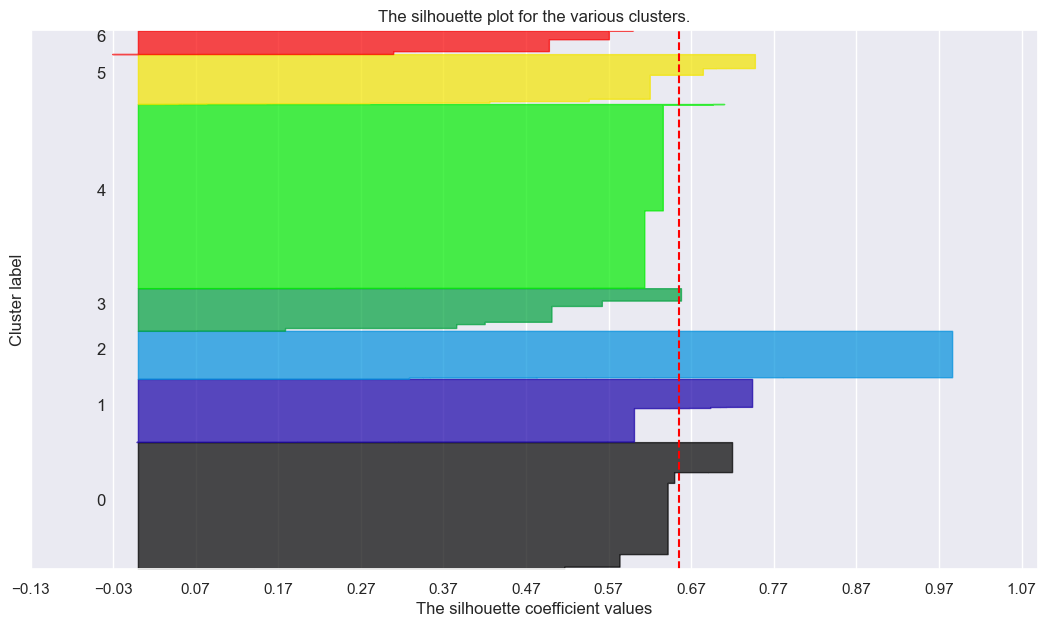

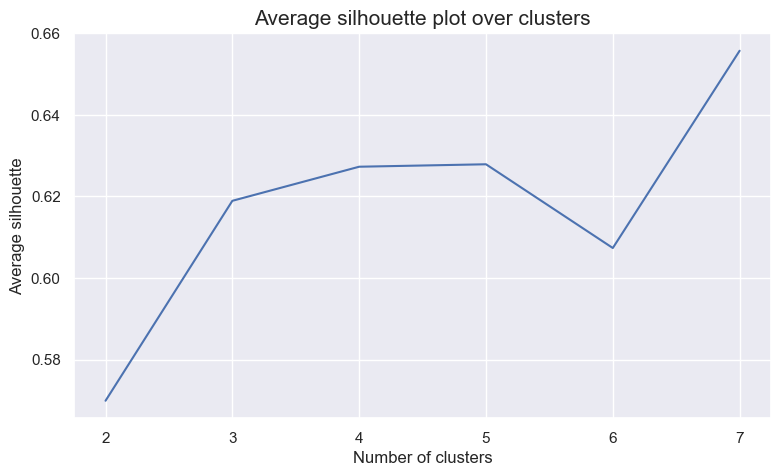

In [570]:

avg_silhouette = []
for nclus in range_clusters:
    if nclus == 1:
        continue
    
    fig = plt.figure(figsize=(13, 7))

    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=42)
    cluster_labels = kmclust.fit_predict(df[behav_cols])

    silhouette_avg = silhouette_score(df[behav_cols], cluster_labels, metric='manhattan')
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(df[behav_cols], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])

    plt.ylim([0, len(df[behav_cols]) + (nclus + 1) * 10])

    plt.yticks([])  
    plt.xticks(np.arange(xmin, xmax, 0.1))
    

plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], 
         avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

R² for K-Means clustering with 3 clusters: 0.6998


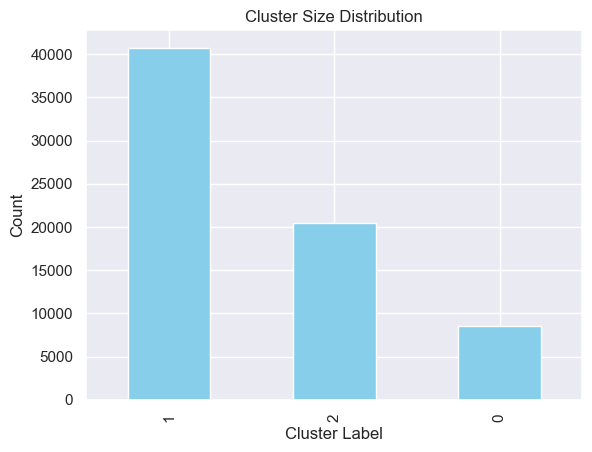

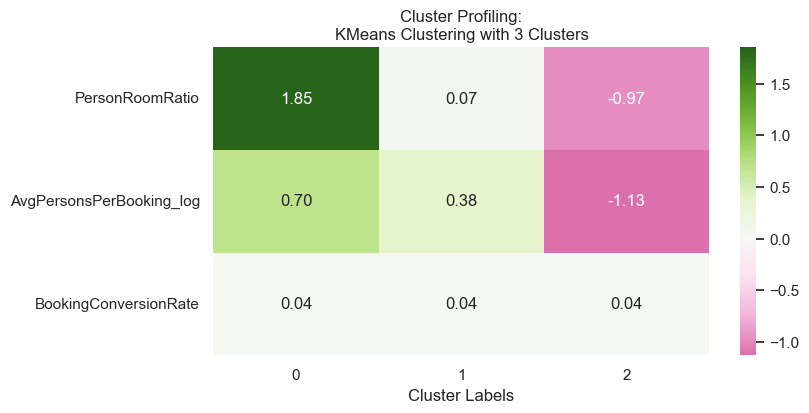

In [582]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Function to compute Sum of Squares Total (SST)
def get_ss(df, feats):
    """
    Computes the total sum of squares (SST) for the given features.
    SST = Sum of squared deviations from the mean.
    """
    grand_mean = df[feats].mean()
    return ((df[feats] - grand_mean) ** 2).sum().sum()

# Function to compute Sum of Squares Within (SSW)
def get_ssw(df, feats, label_col):
    """
    Computes the within-cluster sum of squares (SSW).
    SSW = Sum of squared deviations within each cluster.
    """
    return df.groupby(label_col).apply(lambda g: ((g[feats] - g[feats].mean()) ** 2).sum().sum()).sum()

# Function to compute R² (Proportion of variance explained by clusters)
def get_rsq(df, feats, label_col):
    """
    Computes R-squared (R²) for clustering.
    R² = (SST - SSW) / SST = SSB / SST
    """
    sst = get_ss(df, feats)
    ssw = get_ssw(df, feats, label_col)
    ssb = sst - ssw  # Between-cluster sum of squares
    return ssb / sst  # R² metric

# -------------------------------
# Define number of clusters
num_clusters = 3

# Apply K-Means clustering
kmclust = KMeans(n_clusters=num_clusters, init='k-means++', n_init=15, random_state=42)
km_labels = kmclust.fit_predict(df[behav_cols])

# Normalize the DataFrame (if not already normalized)
normalized_df = pd.DataFrame(df[behav_cols], columns=behav_cols, index=df.index)

# Merge labels with the dataset
df_concat = pd.concat((normalized_df, pd.Series(km_labels, name='labels', index=df.index)), axis=1)

# Compute R² metric
r2_value = get_rsq(df_concat, behav_cols, 'labels')

# Display R² result
print(f"R² for K-Means clustering with {num_clusters} clusters: {r2_value:.4f}")

# Plot Cluster Distribution
df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.title('Cluster Size Distribution')
plt.show()

# Heatmap for Cluster Profiling
fig, ax = plt.subplots(figsize=(8,4))
km_profile = df_concat.groupby('labels').mean().T
sns.heatmap(km_profile, center=0, annot=True, cmap="PiYG", fmt=".2f", ax=ax)
ax.set_xlabel("Cluster Labels")
ax.set_title(f"Cluster Profiling:\nKMeans Clustering with {num_clusters} Clusters")
plt.show()

# Gaussian Mixture Model

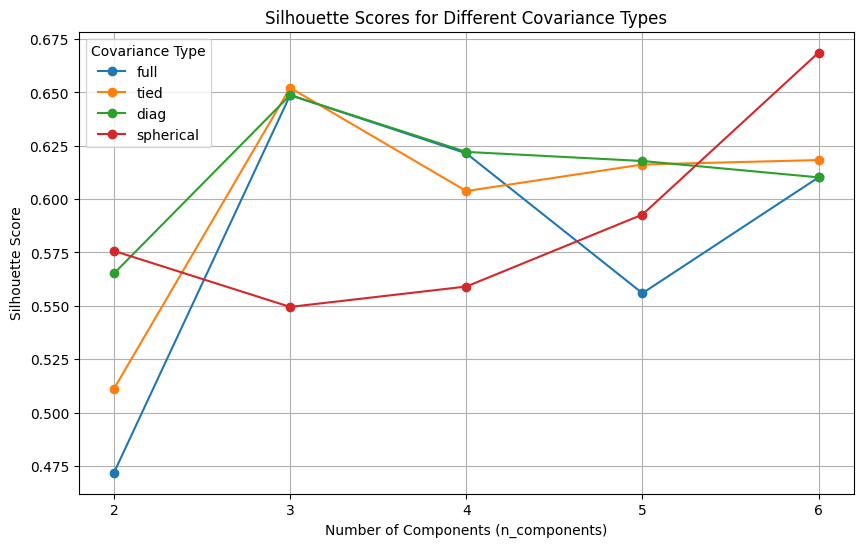

In [11]:

n_components = np.arange(2, 7)
cov_types = ['full', 'tied', 'diag', 'spherical']
scores = {}

for cova in cov_types:
    models = [GaussianMixture(n, covariance_type=cova, n_init=10, random_state=42).fit(df[behav_cols]) 
              for n in n_components]
    
    scores[cova] = [silhouette_score(df[behav_cols], model.predict(df[behav_cols]), metric='manhattan') 
                    for model in models]

plt.figure(figsize=(10, 6))
for cova in cov_types:
    plt.plot(n_components, scores[cova], marker='o', label=f'{cova}')
plt.title('Silhouette Scores for Different Covariance Types')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('Silhouette Score')
plt.xticks(n_components)
plt.legend(title='Covariance Type')
plt.grid(True)
plt.show()


R² for Gaussian Mixture Model with 3 clusters: 0.6711


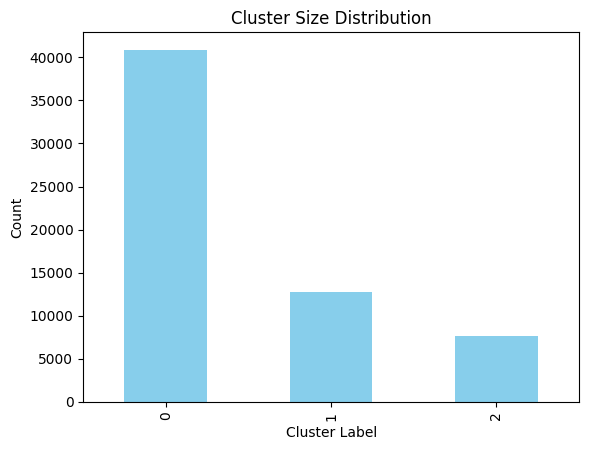

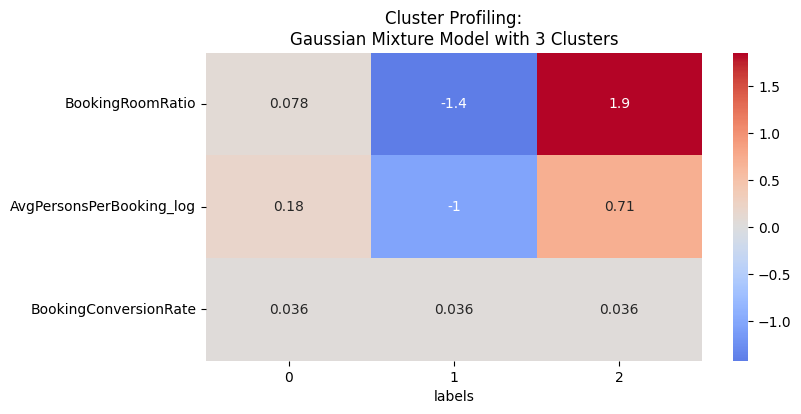

In [12]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture

# Function to compute Sum of Squares Total (SST)
def get_ss(df, feats):
    """
    Computes the total sum of squares (SST) for the given features.
    SST = Sum of squared deviations from the mean.
    """
    grand_mean = df[feats].mean()
    return ((df[feats] - grand_mean) ** 2).sum().sum()

# Function to compute Sum of Squares Within (SSW)
def get_ssw(df, feats, label_col):
    """
    Computes the within-cluster sum of squares (SSW).
    SSW = Sum of squared deviations within each cluster.
    """
    return df.groupby(label_col).apply(lambda g: ((g[feats] - g[feats].mean()) ** 2).sum().sum()).sum()

# Function to compute R² (Proportion of variance explained by clusters)
def get_rsq(df, feats, label_col):
    """
    Computes R-squared (R²) for clustering.
    R² = (SST - SSW) / SST = SSB / SST
    """
    sst = get_ss(df, feats)
    ssw = get_ssw(df, feats, label_col)
    ssb = sst - ssw  # Between-cluster sum of squares
    return ssb / sst  # R² metric

# -------------------------------
# Define number of clusters
num_clusters = 3

# Apply Gaussian Mixture Model (GMM)
gm = GaussianMixture(n_components=num_clusters, covariance_type='tied', n_init=10, random_state=42)
gm_labels = gm.fit_predict(df[behav_cols])

# Merge labels with the dataset
df_concat = pd.concat((df[behav_cols], pd.Series(gm_labels, name='labels', index=df.index)), axis=1)

# Compute R² metric for GMM
r2_value = get_rsq(df_concat, behav_cols, 'labels')

# Display R² result
print(f"R² for Gaussian Mixture Model with {num_clusters} clusters: {r2_value:.4f}")

# Plot Cluster Distribution
df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.title('Cluster Size Distribution')
plt.show()

# Heatmap for Cluster Profiling
fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(df_concat.groupby("labels").mean().T, annot=True, cmap="coolwarm", center=0, ax=ax)
ax.set_title(f"Cluster Profiling:\nGaussian Mixture Model with {num_clusters} Clusters")
plt.show()


## Spending Pattern Perspective

In [8]:
df.columns

Index(['Age', 'DaysSinceCreation', 'PersonsPerRoom', 'BookingConversionRate',
       'BookingRoomRatio', 'BookingsCanceled_log', 'TotalBookings_log',
       'BookingsCheckedIn_log', 'BookingsNoShowed_log', 'RoomNights_log',
       'OtherRevenue_log', 'TotalRevenue_log', 'SpendingPerPerson_log',
       'AverageStayLength_log', 'SpendingPerCheckin_log',
       'AverageRoomPrice_log', 'SpendingPerRoom_log', 'BookingFrequency_log',
       'PersonsNights_log', 'RoomDensity_log', 'AvgPersonsPerBooking_log',
       'BookingDensity_log', 'ExtraRevenueRatio_log', 'AverageLeadTime_log'],
      dtype='object')

In [383]:
spent_cols = ['TotalRevenue_log', 'SpendingPerPerson_log', 'PersonsNights_log', 'OtherRevenue_log']

In [384]:
df[spent_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
TotalRevenue_log,58360.0,-0.073841,0.795612,-2.024232,-0.594682,-0.009872,0.505410,2.194945
SpendingPerPerson_log,58360.0,-0.085937,0.823688,-1.707588,-0.678302,-0.207297,0.394543,2.900796
PersonsNights_log,58360.0,-0.024014,0.898517,-1.986321,-0.374846,0.216906,0.658891,1.777401
OtherRevenue_log,58360.0,-0.051421,0.870302,-2.696131,-0.592682,0.033857,0.573622,2.014221


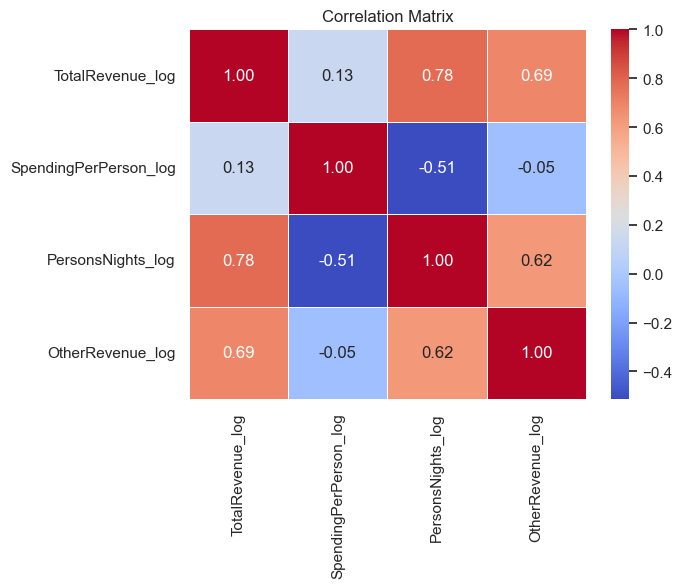

In [385]:

sns.heatmap(df[spent_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


# KMeans Clustering 

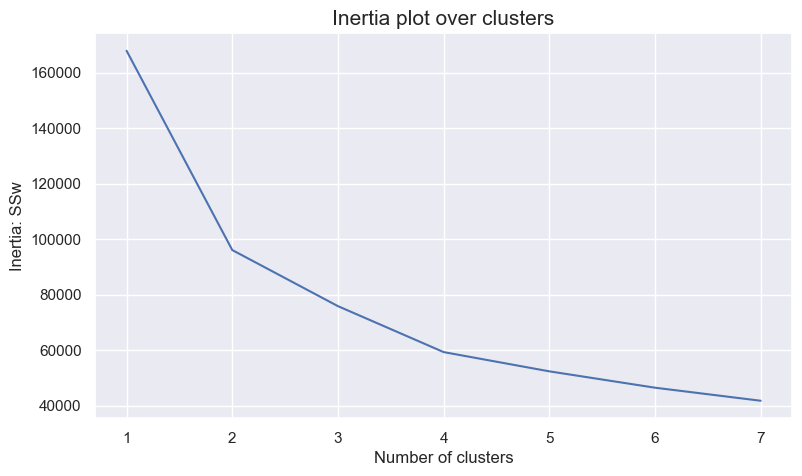

In [386]:

range_clusters = range(1, 8)
inertia = []
for n_clus in range_clusters:  
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=42)
    kmclust.fit(df[spent_cols])
    inertia.append(kmclust.inertia_)
    
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(range_clusters, inertia)
ax.set_xticks(range_clusters)
ax.set_ylabel("Inertia: SSw")
ax.set_xlabel("Number of clusters")
ax.set_title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.40837692344283627
For n_clusters = 3, the average silhouette_score is : 0.3005893884588407
For n_clusters = 4, the average silhouette_score is : 0.32002846190923023
For n_clusters = 5, the average silhouette_score is : 0.27824993749940086
For n_clusters = 6, the average silhouette_score is : 0.27999806775982766
For n_clusters = 7, the average silhouette_score is : 0.2700701869016553


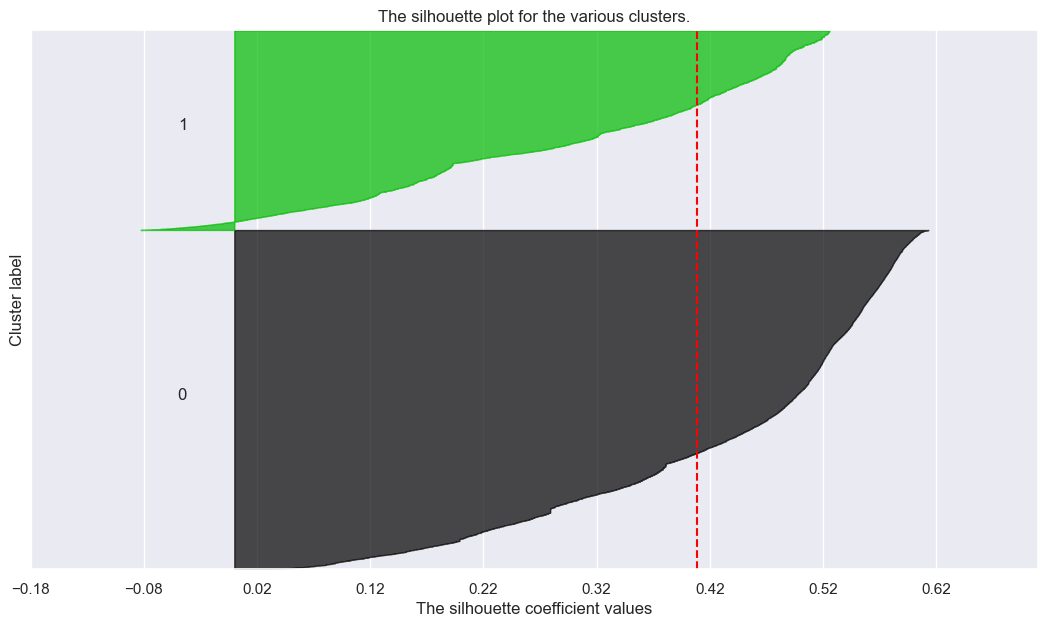

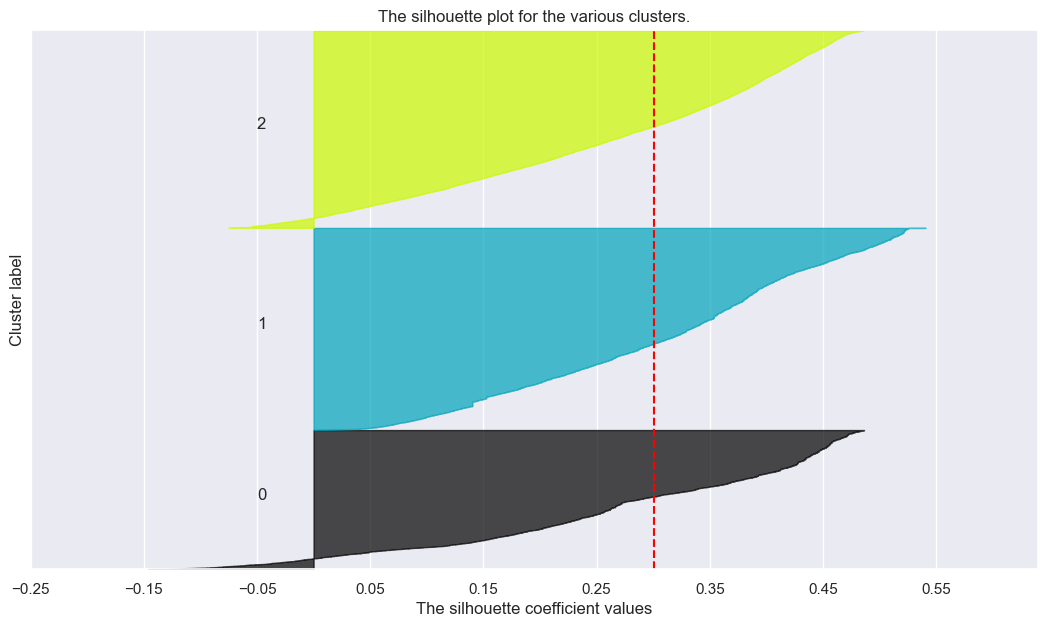

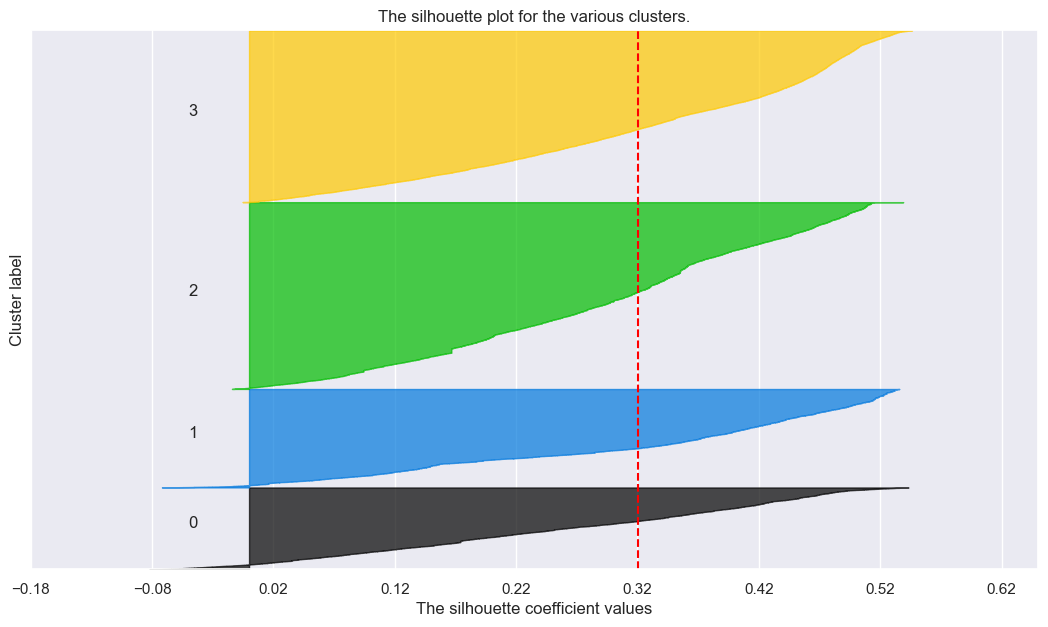

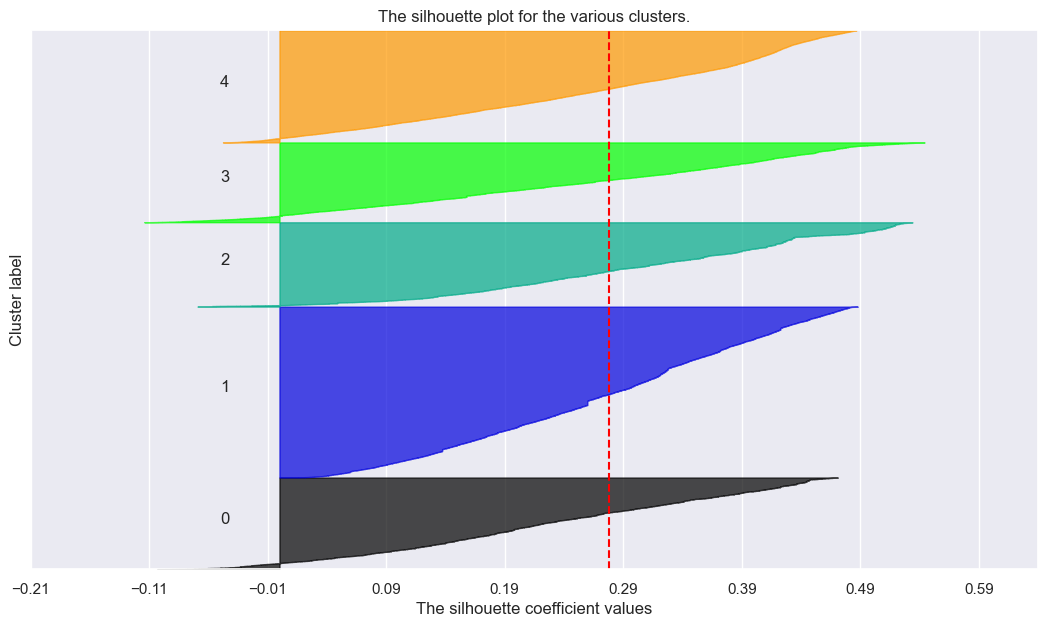

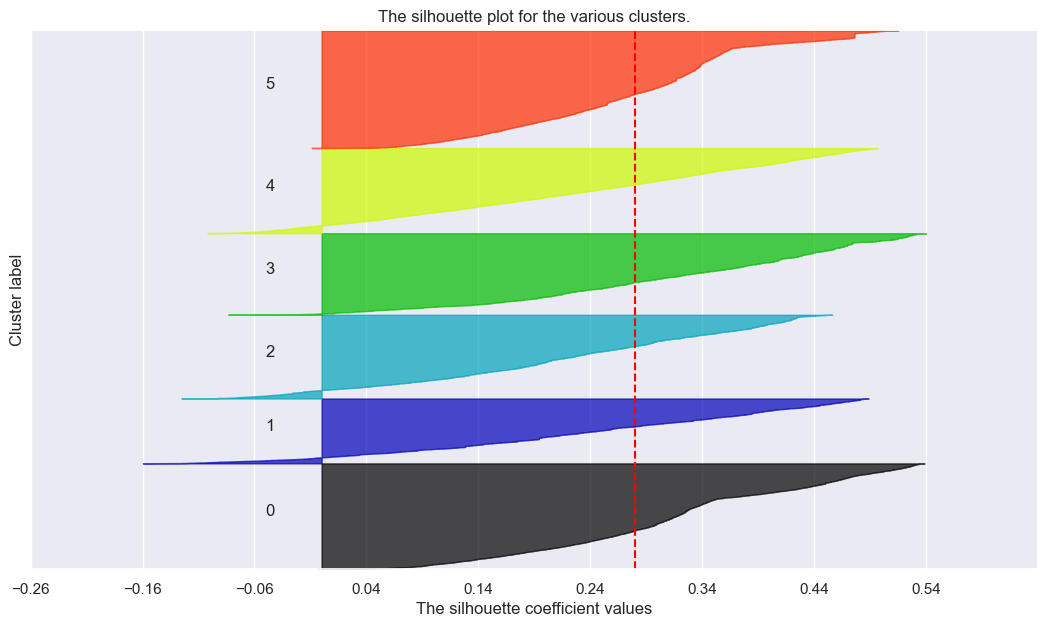

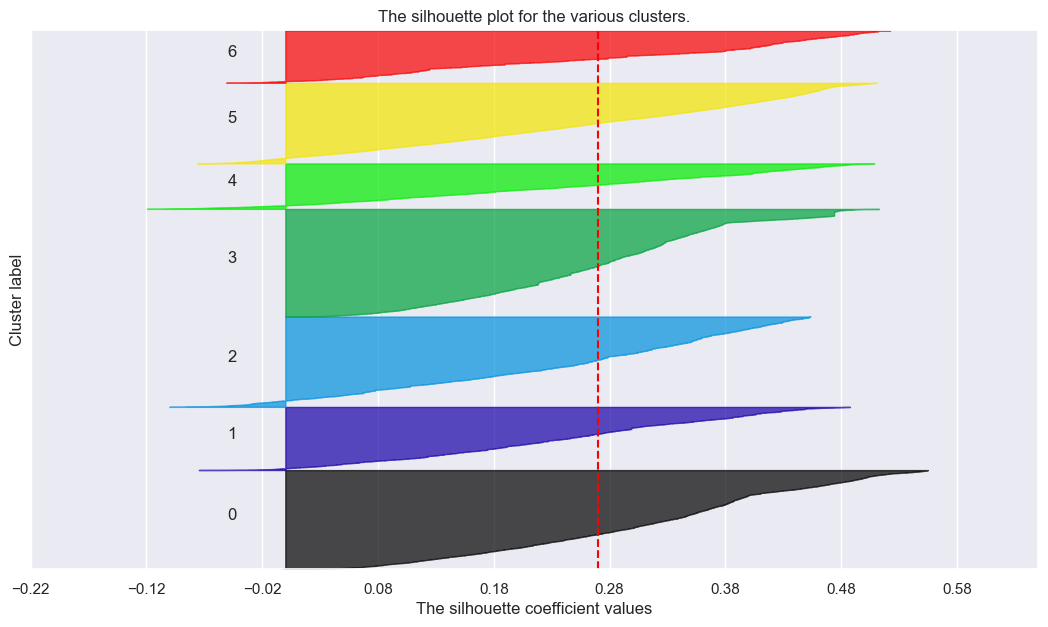

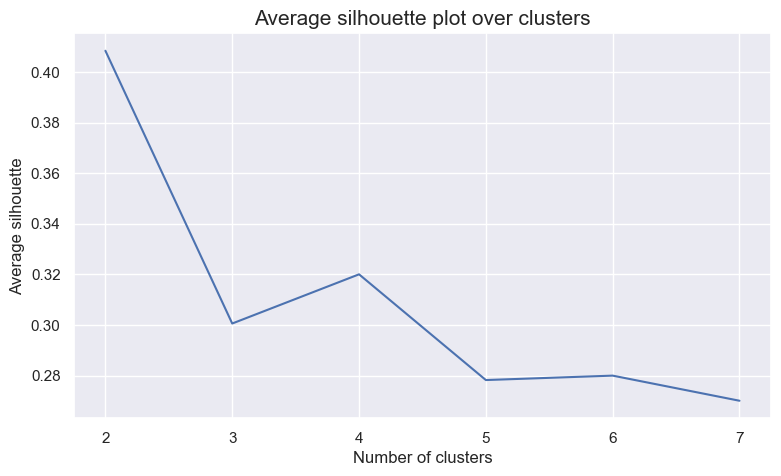

In [387]:

avg_silhouette = []
for nclus in range_clusters:
    if nclus == 1:
        continue
    
    fig = plt.figure(figsize=(13, 7))

    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=42)
    cluster_labels = kmclust.fit_predict(df[spent_cols])

    silhouette_avg = silhouette_score(df[spent_cols], cluster_labels, metric='manhattan')
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(df[spent_cols], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])

    plt.ylim([0, len(df[spent_cols]) + (nclus + 1) * 10])

    plt.yticks([])  
    plt.xticks(np.arange(xmin, xmax, 0.1))
    

plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], 
         avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

R² for K-Means clustering with 3 clusters: 0.5479


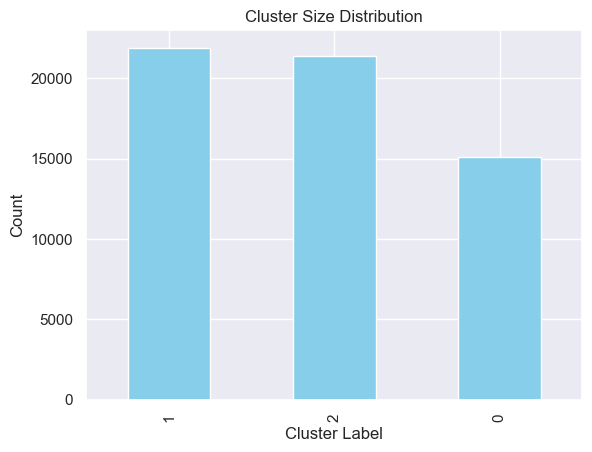

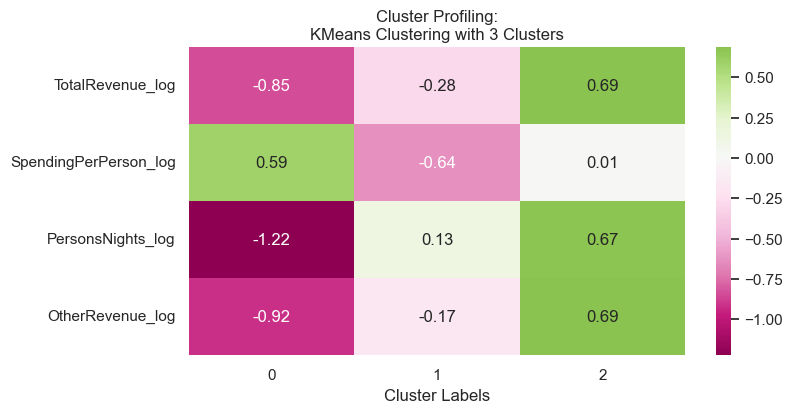

In [389]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Function to compute Sum of Squares Total (SST)
def get_ss(df, feats):
    """
    Computes the total sum of squares (SST) for the given features.
    SST = Sum of squared deviations from the mean.
    """
    grand_mean = df[feats].mean()
    return ((df[feats] - grand_mean) ** 2).sum().sum()

# Function to compute Sum of Squares Within (SSW)
def get_ssw(df, feats, label_col):
    """
    Computes the within-cluster sum of squares (SSW).
    SSW = Sum of squared deviations within each cluster.
    """
    return df.groupby(label_col).apply(lambda g: ((g[feats] - g[feats].mean()) ** 2).sum().sum()).sum()

# Function to compute R² (Proportion of variance explained by clusters)
def get_rsq(df, feats, label_col):
    """
    Computes R-squared (R²) for clustering.
    R² = (SST - SSW) / SST = SSB / SST
    """
    sst = get_ss(df, feats)
    ssw = get_ssw(df, feats, label_col)
    ssb = sst - ssw  # Between-cluster sum of squares
    return ssb / sst  # R² metric

# -------------------------------
# Define number of clusters
num_clusters = 3

# Apply K-Means clustering
kmclust = KMeans(n_clusters=num_clusters, init='k-means++', n_init=15, random_state=42)
km_labels = kmclust.fit_predict(df[spent_cols])

# Normalize the DataFrame (if not already normalized)
normalized_df = pd.DataFrame(df[spent_cols], columns=spent_cols, index=df.index)

# Merge labels with the dataset
df_concat = pd.concat((normalized_df, pd.Series(km_labels, name='labels', index=df.index)), axis=1)

# Compute R² metric
r2_value = get_rsq(df_concat, spent_cols, 'labels')

# Display R² result
print(f"R² for K-Means clustering with {num_clusters} clusters: {r2_value:.4f}")

# Plot Cluster Distribution
df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.title('Cluster Size Distribution')
plt.show()

# Heatmap for Cluster Profiling
fig, ax = plt.subplots(figsize=(8,4))
km_profile = df_concat.groupby('labels').mean().T
sns.heatmap(km_profile, center=0, annot=True, cmap="PiYG", fmt=".2f", ax=ax)
ax.set_xlabel("Cluster Labels")
ax.set_title(f"Cluster Profiling:\nKMeans Clustering with {num_clusters} Clusters")
plt.show()

# Gaussian Mixture Model

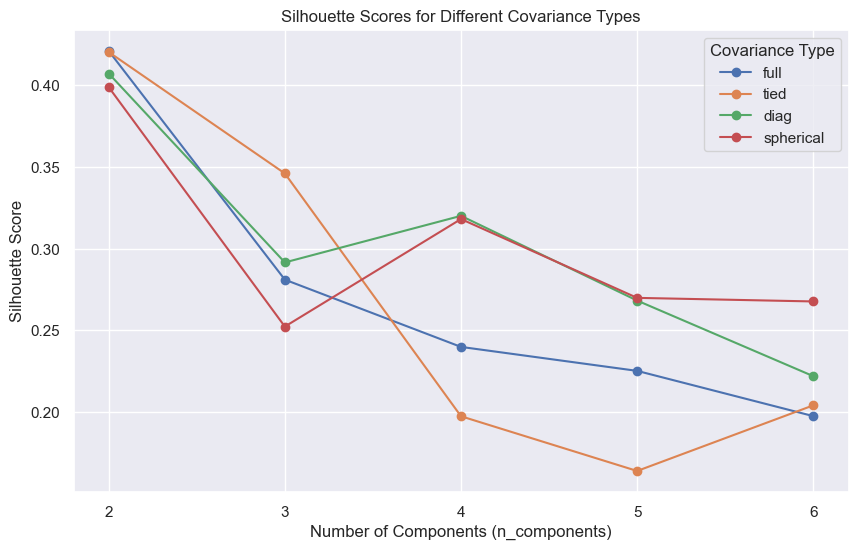

In [390]:

n_components = np.arange(2, 7)
cov_types = ['full', 'tied', 'diag', 'spherical']
scores = {}

for cova in cov_types:
    models = [GaussianMixture(n, covariance_type=cova, n_init=10, random_state=42).fit(df[spent_cols]) 
              for n in n_components]
    
    scores[cova] = [silhouette_score(df[spent_cols], model.predict(df[spent_cols]), metric='manhattan') 
                    for model in models]

plt.figure(figsize=(10, 6))
for cova in cov_types:
    plt.plot(n_components, scores[cova], marker='o', label=f'{cova}')
plt.title('Silhouette Scores for Different Covariance Types')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('Silhouette Score')
plt.xticks(n_components)
plt.legend(title='Covariance Type')
plt.grid(True)
plt.show()


R² for Gaussian Mixture Model with 3 clusters: 0.5061


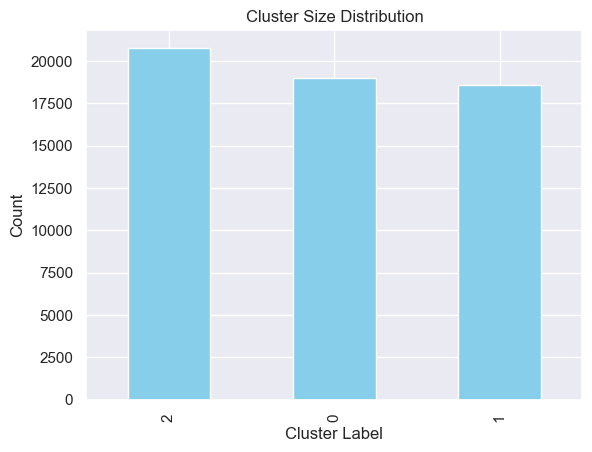

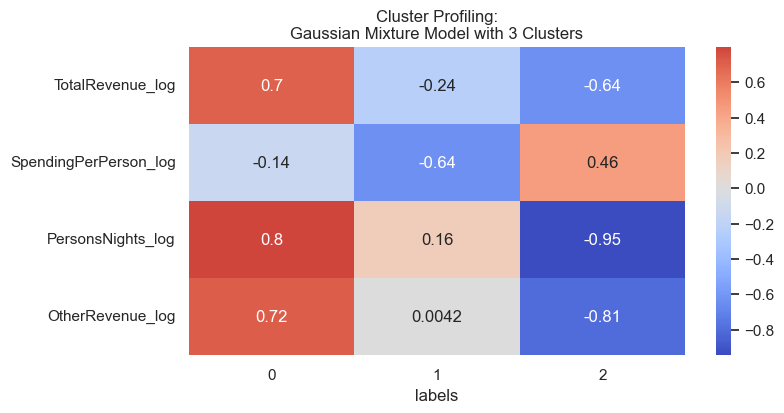

In [391]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture

# Function to compute Sum of Squares Total (SST)
def get_ss(df, feats):
    """
    Computes the total sum of squares (SST) for the given features.
    SST = Sum of squared deviations from the mean.
    """
    grand_mean = df[feats].mean()
    return ((df[feats] - grand_mean) ** 2).sum().sum()

# Function to compute Sum of Squares Within (SSW)
def get_ssw(df, feats, label_col):
    """
    Computes the within-cluster sum of squares (SSW).
    SSW = Sum of squared deviations within each cluster.
    """
    return df.groupby(label_col).apply(lambda g: ((g[feats] - g[feats].mean()) ** 2).sum().sum()).sum()

# Function to compute R² (Proportion of variance explained by clusters)
def get_rsq(df, feats, label_col):
    """
    Computes R-squared (R²) for clustering.
    R² = (SST - SSW) / SST = SSB / SST
    """
    sst = get_ss(df, feats)
    ssw = get_ssw(df, feats, label_col)
    ssb = sst - ssw  # Between-cluster sum of squares
    return ssb / sst  # R² metric

# -------------------------------
# Define number of clusters
num_clusters = 3

# Apply Gaussian Mixture Model (GMM)
gm = GaussianMixture(n_components=num_clusters, covariance_type='spherical', n_init=10, random_state=42)
gm_labels = gm.fit_predict(df[spent_cols])

# Merge labels with the dataset
df_concat = pd.concat((df[spent_cols], pd.Series(gm_labels, name='labels', index=df.index)), axis=1)

# Compute R² metric for GMM
r2_value = get_rsq(df_concat, spent_cols, 'labels')

# Display R² result
print(f"R² for Gaussian Mixture Model with {num_clusters} clusters: {r2_value:.4f}")

# Plot Cluster Distribution
df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.title('Cluster Size Distribution')
plt.show()

# Heatmap for Cluster Profiling
fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(df_concat.groupby("labels").mean().T, annot=True, cmap="coolwarm", center=0, ax=ax)
ax.set_title(f"Cluster Profiling:\nGaussian Mixture Model with {num_clusters} Clusters")
plt.show()


**GMM Clusters**:

Cluster 0: Customers with higher spending and longer stays, similar to K-Means.\
Cluster 1: Customers with lower spending and shorter stays, resembling the budget-conscious segment.

# Merging the Perspectives

# Booking-Behavior Clustering Solution

In [571]:
behav_cols = ['PersonRoomRatio', 'AvgPersonsPerBooking_log', 'BookingConversionRate']

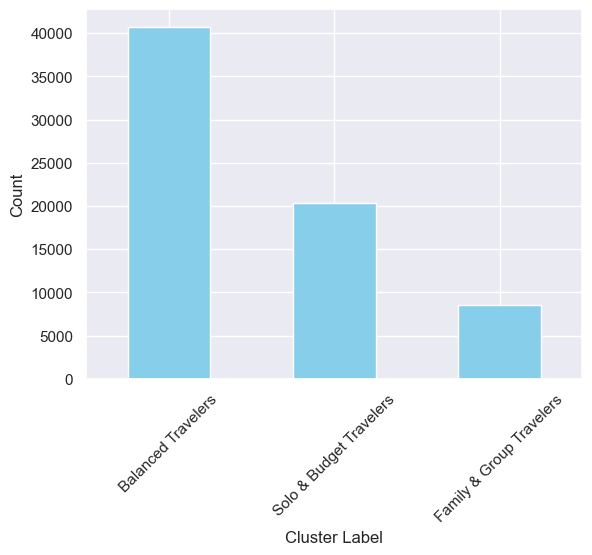

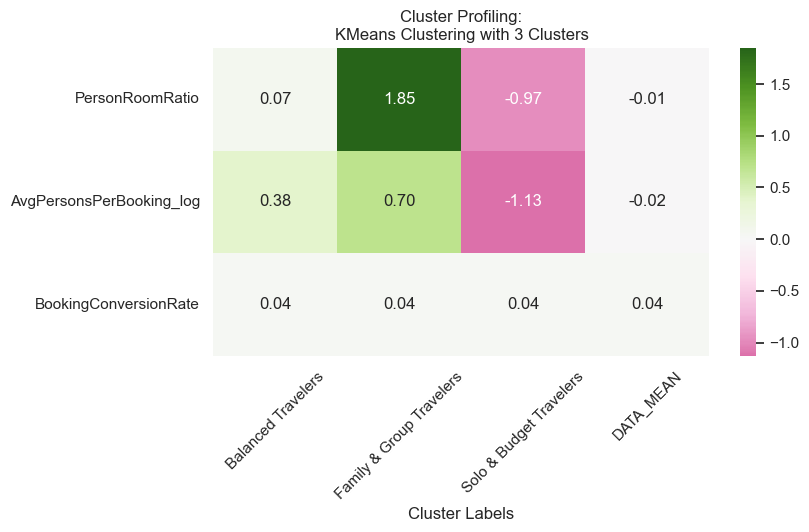

In [598]:
kmclust = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=42)
km_labels = kmclust.fit_predict(df[behav_cols])
mapping = {0: 'Family & Group Travelers', 1: 'Balanced Travelers', 2: 'Solo & Budget Travelers'}

km_labels = pd.Series(km_labels, name='labels', index=df.index)
km_labels = km_labels.map(mapping)

df_concat = pd.concat((df[behav_cols], pd.Series(km_labels, name='labels', index=df.index)), axis=1)

# mapping = {0: 'Balanced Travelers', 1: 'Solo & Budget Travelers', 2: 'Family & Group Travelers'}
# df_concat['labels'] = df_concat['labels'].map(mapping)
df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xticks(rotation=45)
plt.xlabel('Cluster Label')
plt.ylabel('Count')




fig, ax = plt.subplots(figsize=(8,4))
km_profile = df_concat.groupby('labels').mean().T

data_mean = df[behav_cols].mean().T
data_mean = pd.DataFrame(data_mean, columns=['DATA_MEAN'])

df_all = pd.concat([km_profile, data_mean], axis=1)

sns.heatmap(df_all,
            center=0, annot=True, cmap="PiYG", fmt=".2f",
            ax=ax)
plt.xticks(rotation=45)
ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nKMeans Clustering with 3 Clusters")
plt.show()

**Balanced Travelers**: Guests with average spending and booking behavior, booking in moderate group sizes.\
**Solo & Budget Travelers**: Individual travelers or budget-conscious guests who book fewer rooms and stay alone\
**Family & Group Travelers**: Families, groups, or premium customers who book more rooms per stay.

In [599]:

km_profile

labels,Balanced Travelers,Family & Group Travelers,Solo & Budget Travelers
PersonRoomRatio,0.072783,1.851359,-0.970124
AvgPersonsPerBooking_log,0.379758,0.699657,-1.129042
BookingConversionRate,0.039245,0.039245,0.039245


In [600]:
df_all

,Balanced Travelers,Family & Group Travelers,Solo & Budget Travelers,DATA_MEAN
PersonRoomRatio,0.072783,1.851359,-0.970124,-0.013461
AvgPersonsPerBooking_log,0.379758,0.699657,-1.129042,-0.022399
BookingConversionRate,0.039245,0.039245,0.039245,0.039245


In [601]:
r2 = get_rsq(df_concat, behav_cols, 'labels')
r2

0.6998446120100037

# Spending Clustering Solution

In [602]:
spent_cols = ['TotalRevenue_log', 'SpendingPerPerson_log', 'PersonsNights_log', 'OtherRevenue_log']

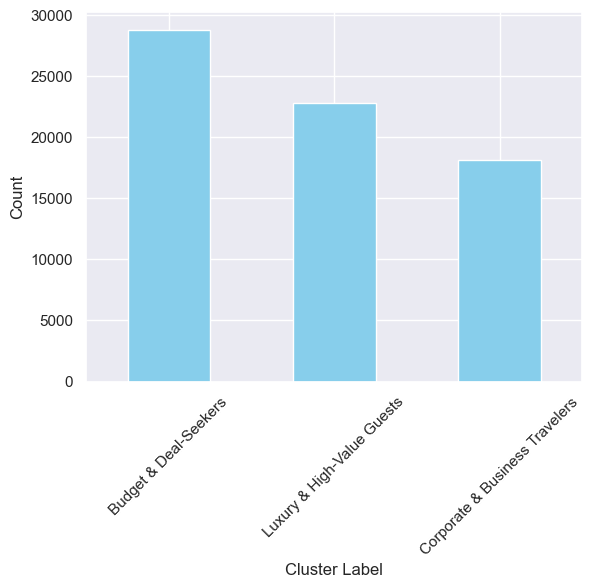

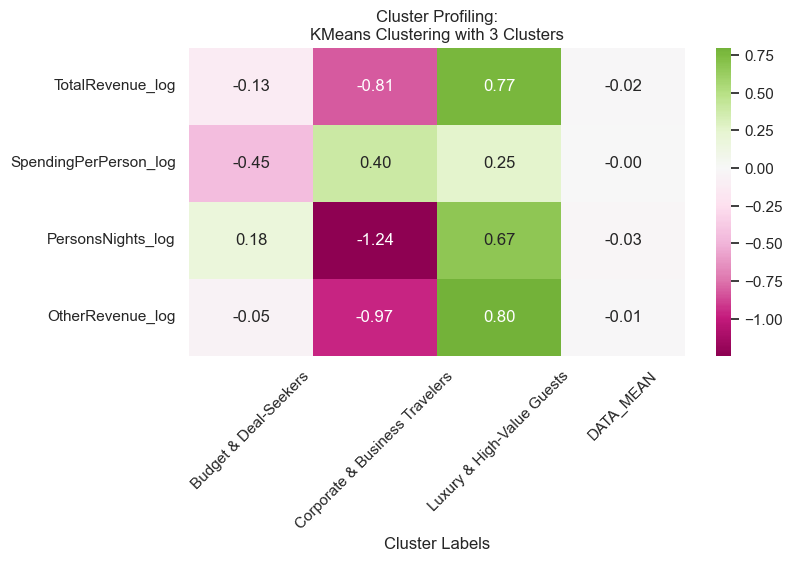

In [603]:
km2clust = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=42)
km2_labels = kmclust.fit_predict(df[spent_cols])
mapping = {0: 'Budget & Deal-Seekers', 1: 'Corporate & Business Travelers', 2: 'Luxury & High-Value Guests'}

km2_labels = pd.Series(km2_labels, name='labels', index=df.index)
km2_labels = km2_labels.map(mapping)

df_concat = pd.concat((df[spent_cols], pd.Series(km2_labels, name='labels', index=df.index)), axis=1)

# mapping = {0: 'Budget & Deal-Seekers', 1: 'Corporate & Business Travelers', 2: 'Luxury & High-Value Guests'}
# df_concat['labels'] = df_concat['labels'].map(mapping)
df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xticks(rotation=45)
plt.xlabel('Cluster Label')
plt.ylabel('Count')




fig, ax = plt.subplots(figsize=(8,4))
km2_profile = df_concat.groupby('labels').mean().T

data_mean = df[spent_cols].mean().T
data_mean = pd.DataFrame(data_mean, columns=['DATA_MEAN'])

df_all = pd.concat([km2_profile, data_mean], axis=1)

sns.heatmap(df_all,
            center=0, annot=True, cmap="PiYG", fmt=".2f",
            ax=ax)
plt.xticks(rotation=45)
ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nKMeans Clustering with 3 Clusters")
plt.show()

In [604]:

km2_profile

labels,Budget & Deal-Seekers,Corporate & Business Travelers,Luxury & High-Value Guests
TotalRevenue_log,-0.134372,-0.814716,0.771680
SpendingPerPerson_log,-0.453780,0.395706,0.253378
PersonsNights_log,0.181938,-1.244934,0.668167
OtherRevenue_log,-0.051759,-0.970674,0.799589


In [605]:
df_all

,Budget & Deal-Seekers,Corporate & Business Travelers,Luxury & High-Value Guests,DATA_MEAN
TotalRevenue_log,-0.134372,-0.814716,0.771680,-0.015136
SpendingPerPerson_log,-0.453780,0.395706,0.253378,-0.002073
PersonsNights_log,0.181938,-1.244934,0.668167,-0.029918
OtherRevenue_log,-0.051759,-0.970674,0.799589,-0.012373


## # Merging the Perspectives

In [606]:
columns_to_use = ['PersonRoomRatio', 'AvgPersonsPerBooking_log', 'BookingConversionRate', 
                  'TotalRevenue_log', 'SpendingPerPerson_log', 'PersonsNights_log', 'OtherRevenue_log']

In [607]:
# Split variables into perspectives (example, requires critical thinking and domain knowledge)
behavior_cols = [
    'PersonRoomRatio', 'AvgPersonsPerBooking_log', 'BookingConversionRate'
]

spending_cols = [
    'TotalRevenue_log', 'SpendingPerPerson_log', 'PersonsNights_log', 'OtherRevenue_log' 
]

df_bh = df[behavior_cols].copy()
df_sp = df[spending_cols].copy()

In [608]:
df["behavior_labels"] = km_labels
df["spending_labels"] = km2_labels

<Axes: xlabel='behavior_labels'>

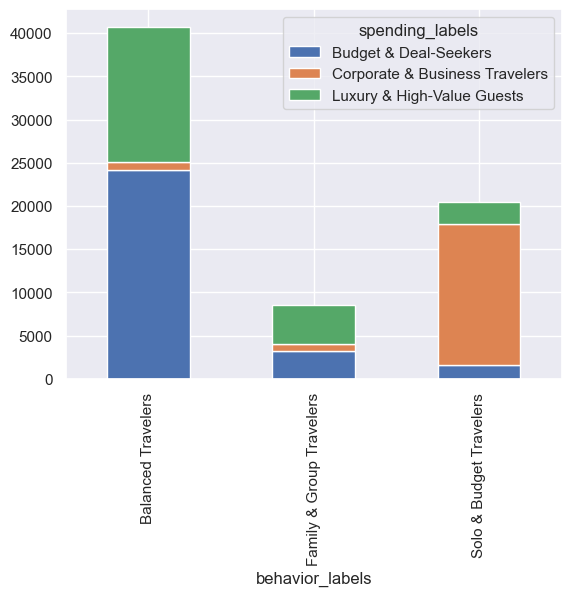

In [609]:
pd.crosstab(df['behavior_labels'],
            df['spending_labels']).plot(kind='bar', stacked=True)

In [610]:
df_centroids = df.groupby(['behavior_labels', 'spending_labels'])\
    [columns_to_use].mean()
df_centroids

PersonRoomRatio  \
behavior_labels          spending_labels                                   
Balanced Travelers       Budget & Deal-Seekers                  0.081972   
                         Corporate & Business Travelers         0.084564   
                         Luxury & High-Value Guests             0.057966   
Family & Group Travelers Budget & Deal-Seekers                  1.853880   
                         Corporate & Business Travelers         1.608241   
                         Luxury & High-Value Guests             1.894475   
Solo & Budget Travelers  Budget & Deal-Seekers                 -1.319732   
                         Corporate & Business Travelers        -0.880535   
                         Luxury & High-Value Guests            -1.338962   

                                                         AvgPersonsPerBooking_log  \
behavior_labels          spending_labels                                            
Balanced Travelers       Budget & Deal-Seekers                           0.202334   
                         Corporate & Business Travelers                 -0.336189   
                         Luxury & High-Value Guests                      0.694402   
Family & Group Travelers Budget & Deal-Seekers                           0.468093   
                         Corporate & Business Travelers                 -0.723165   
                         Luxury & High-Value Guests                      1.122429   
Solo & Budget Travelers  Budget & Deal-Seekers                          -0.446448   
                         Corporate & Business Travelers                 -1.302541   
                         Luxury & High-Value Guests                     -0.418151   

                                                         BookingConversionRate  \
behavior_labels          spending_labels                                         
Balanced Travelers       Budget & Deal-Seekers                        0.039245   
                         Corporate & Business Travelers               0.039245   
                         Luxury & High-Value Guests                   0.039245   
Family & Group Travelers Budget & Deal-Seekers                        0.039245   
                         Corporate & Business Travelers               0.039245   
                         Luxury & High-Value Guests                   0.039245   
Solo & Budget Travelers  Budget & Deal-Seekers                        0.039245   
                         Corporate & Business Travelers               0.039245   
                         Luxury & High-Value Guests                   0.039245   

                                                         TotalRevenue_log  \
behavior_labels          spending_labels                                    
Balanced Travelers       Budget & Deal-Seekers                  -0.152059   
                         Corporate & Business Travelers         -0.480569   
                         Luxury & High-Value Guests              0.765846   
Family & Group Travelers Budget & Deal-Seekers                  -0.054644   
                         Corporate & Business Travelers         -0.858254   
                         Luxury & High-Value Guests              0.829245   
Solo & Budget Travelers  Budget & Deal-Seekers                  -0.021303   
                         Corporate & Business Travelers         -0.831229   
                         Luxury & High-Value Guests              0.703248   

                                                         SpendingPerPerson_log  \
behavior_labels          spending_labels                                         
Balanced Travelers       Budget & Deal-Seekers                       -0.477675   
                         Corporate & Business Travelers              -0.314102   
                         Luxury & High-Value Guests                   0.212850   
Family & Group Travelers Budget & Deal-Seekers                       -0.627315   
                         Corporate & Busi

In [551]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Define cluster range
range_clusters = range(2, min(8, df_centroids.shape[0]))  # Ensure clusters are valid
linkage_methods = ['ward', 'complete', 'average']
distance_metrics = ['euclidean', 'cosine', 'manhattan']

avg_silhouette = {}

for linkage_method in linkage_methods:
    print(f"Linkage method: {linkage_method}")
    for dist in distance_metrics:
        print(f"Distance metric: {dist}")
        
        # Ward linkage only works with Euclidean distance
        if (dist in ["cosine", "manhattan"]) and linkage_method == "ward":
            continue
        
        avg_silhouette[(linkage_method, dist)] = []
        
        for nclus in range_clusters:
            if nclus >= df_centroids.shape[0]:  # Skip if clusters exceed data points
                print(f"Skipping n_clusters={nclus} (exceeds available data points)")
                continue

            # Apply Agglomerative Clustering
            aggclust = AgglomerativeClustering(n_clusters=nclus, linkage=linkage_method, metric=dist)
            cluster_labels = aggclust.fit_predict(df_centroids)

            # Compute silhouette score only when at least 2 clusters exist
            if len(set(cluster_labels)) > 1:
                silhouette_avg = silhouette_score(df_centroids, cluster_labels, metric=dist)
                avg_silhouette[(linkage_method, dist)].append(silhouette_avg)
                print(f"For n_clusters = {nclus}, silhouette_score = {silhouette_avg:.4f}")
            else:
                print(f"Skipping silhouette score for n_clusters={nclus} (single cluster issue)")

        print("-----------------------------------\n")


Linkage method: ward
Distance metric: euclidean
For n_clusters = 2, silhouette_score = 0.4161
For n_clusters = 3, silhouette_score = 0.4221
For n_clusters = 4, silhouette_score = 0.3145
For n_clusters = 5, silhouette_score = 0.2851
For n_clusters = 6, silhouette_score = 0.2158
For n_clusters = 7, silhouette_score = 0.1875
-----------------------------------

Distance metric: cosine
Distance metric: manhattan
Linkage method: complete
Distance metric: euclidean
For n_clusters = 2, silhouette_score = 0.4637
For n_clusters = 3, silhouette_score = 0.4335
For n_clusters = 4, silhouette_score = 0.3115
For n_clusters = 5, silhouette_score = 0.2851
For n_clusters = 6, silhouette_score = 0.2158
For n_clusters = 7, silhouette_score = 0.1875
-----------------------------------

Distance metric: cosine
For n_clusters = 2, silhouette_score = 0.7290
For n_clusters = 3, silhouette_score = 0.5824
For n_clusters = 4, silhouette_score = 0.6132
For n_clusters = 5, silhouette_score = 0.4679
For n_clusters 

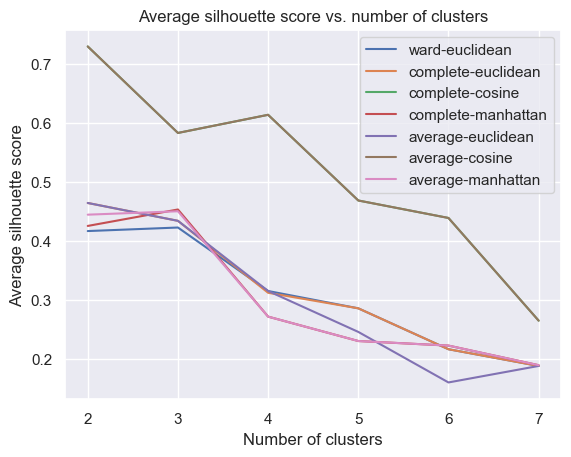

In [552]:
for key, val in avg_silhouette.items():
    sns.lineplot(x=range_clusters, y=val, label=f"{key[0]}-{key[1]}")
plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette score")
plt.title("Average silhouette score vs. number of clusters")
plt.legend()
plt.show()

In [611]:
linkage = 'complete'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='manhattan', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids)

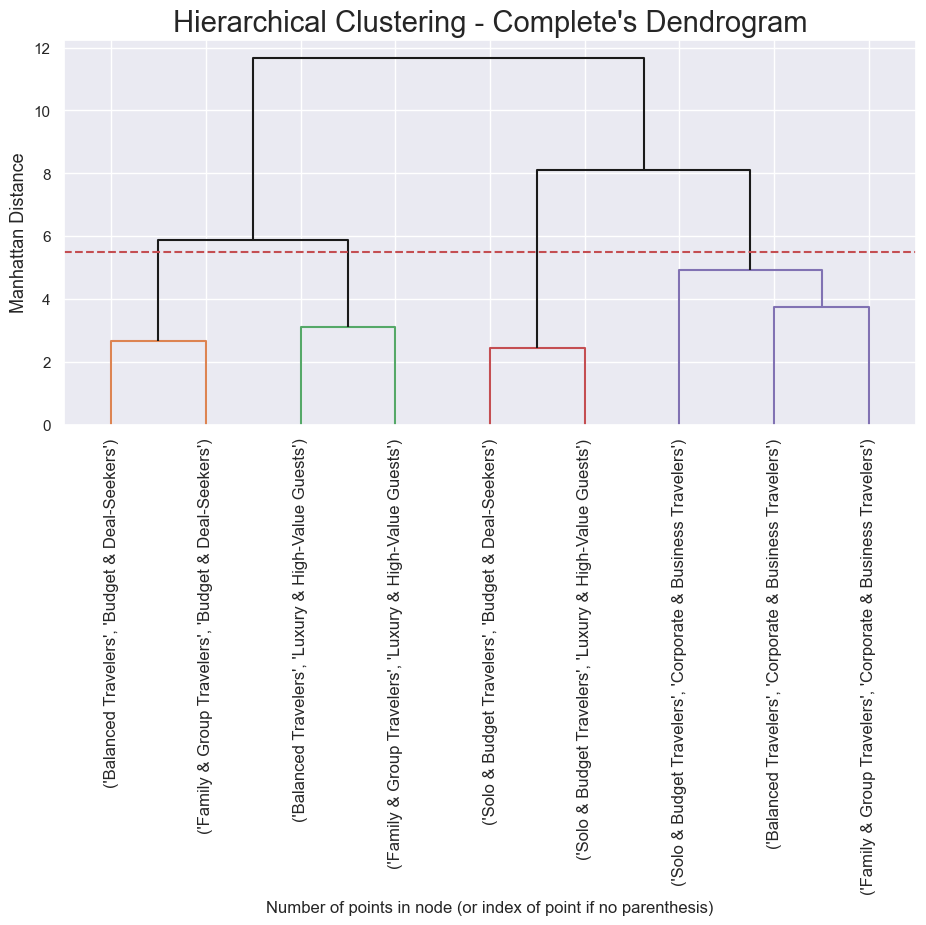

In [614]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned

y_threshold = 5.5
# y_threshold = 3.3

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.xticks(rotation=90)
plt.ylabel(f'Manhattan Distance', fontsize=13)
plt.show()

In [615]:
hclust = AgglomerativeClustering(
    linkage='complete', 
    metric='manhattan', 
    n_clusters=4
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids 

PersonRoomRatio  \
behavior_labels          spending_labels                                   
Balanced Travelers       Budget & Deal-Seekers                  0.081972   
                         Corporate & Business Travelers         0.084564   
                         Luxury & High-Value Guests             0.057966   
Family & Group Travelers Budget & Deal-Seekers                  1.853880   
                         Corporate & Business Travelers         1.608241   
                         Luxury & High-Value Guests             1.894475   
Solo & Budget Travelers  Budget & Deal-Seekers                 -1.319732   
                         Corporate & Business Travelers        -0.880535   
                         Luxury & High-Value Guests            -1.338962   

                                                         AvgPersonsPerBooking_log  \
behavior_labels          spending_labels                                            
Balanced Travelers       Budget & Deal-Seekers                           0.202334   
                         Corporate & Business Travelers                 -0.336189   
                         Luxury & High-Value Guests                      0.694402   
Family & Group Travelers Budget & Deal-Seekers                           0.468093   
                         Corporate & Business Travelers                 -0.723165   
                         Luxury & High-Value Guests                      1.122429   
Solo & Budget Travelers  Budget & Deal-Seekers                          -0.446448   
                         Corporate & Business Travelers                 -1.302541   
                         Luxury & High-Value Guests                     -0.418151   

                                                         BookingConversionRate  \
behavior_labels          spending_labels                                         
Balanced Travelers       Budget & Deal-Seekers                        0.039245   
                         Corporate & Business Travelers               0.039245   
                         Luxury & High-Value Guests                   0.039245   
Family & Group Travelers Budget & Deal-Seekers                        0.039245   
                         Corporate & Business Travelers               0.039245   
                         Luxury & High-Value Guests                   0.039245   
Solo & Budget Travelers  Budget & Deal-Seekers                        0.039245   
                         Corporate & Business Travelers               0.039245   
                         Luxury & High-Value Guests                   0.039245   

                                                         TotalRevenue_log  \
behavior_labels          spending_labels                                    
Balanced Travelers       Budget & Deal-Seekers                  -0.152059   
                         Corporate & Business Travelers         -0.480569   
                         Luxury & High-Value Guests              0.765846   
Family & Group Travelers Budget & Deal-Seekers                  -0.054644   
                         Corporate & Business Travelers         -0.858254   
                         Luxury & High-Value Guests              0.829245   
Solo & Budget Travelers  Budget & Deal-Seekers                  -0.021303   
                         Corporate & Business Travelers         -0.831229   
                         Luxury & High-Value Guests              0.703248   

                                                         SpendingPerPerson_log  \
behavior_labels          spending_labels                                         
Balanced Travelers       Budget & Deal-Seekers                       -0.477675   
                         Corporate & Business Travelers              -0.314102   
                         Luxury & High-Value Guests                   0.212850   
Family & Group Travelers Budget & Deal-Seekers                       -0.627315   
                         Corporate & Busi

In [616]:
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper

{('Balanced Travelers', 'Budget & Deal-Seekers'): 3,
 ('Balanced Travelers', 'Corporate & Business Travelers'): 0,
 ('Balanced Travelers', 'Luxury & High-Value Guests'): 1,
 ('Family & Group Travelers', 'Budget & Deal-Seekers'): 3,
 ('Family & Group Travelers', 'Corporate & Business Travelers'): 0,
 ('Family & Group Travelers', 'Luxury & High-Value Guests'): 1,
 ('Solo & Budget Travelers', 'Budget & Deal-Seekers'): 2,
 ('Solo & Budget Travelers', 'Corporate & Business Travelers'): 0,
 ('Solo & Budget Travelers', 'Luxury & High-Value Guests'): 2}

In [617]:
reversed_data = {}
for key, value in cluster_mapper.items():
    if value not in reversed_data:
        reversed_data[value] = []  # Create list if value doesn't exist
    reversed_data[value].append(key)  # Append keys to the value

# Display the result
for value, keys in reversed_data.items():
    print(f"{value}: {keys}")

3: [('Balanced Travelers', 'Budget & Deal-Seekers'), ('Family & Group Travelers', 'Budget & Deal-Seekers')]
0: [('Balanced Travelers', 'Corporate & Business Travelers'), ('Family & Group Travelers', 'Corporate & Business Travelers'), ('Solo & Budget Travelers', 'Corporate & Business Travelers')]
1: [('Balanced Travelers', 'Luxury & High-Value Guests'), ('Family & Group Travelers', 'Luxury & High-Value Guests')]
2: [('Solo & Budget Travelers', 'Budget & Deal-Seekers'), ('Solo & Budget Travelers', 'Luxury & High-Value Guests')]


In [618]:
df_ = df.copy()

df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['behavior_labels'], row['spending_labels'])
    ], axis=1
)

df_ 

,ID,Nationality,DistributionChannel,MarketSegment,SRAccessibleRoom,SRCrib,SRNoAlcoholInMiniBar,SRQuietRoom,PersonRoomRatio,BookingConversionRate,...,DistanceElevatorAsked,OtherRevenue_log,TotalRevenue_log,SpendingPerPerson_log,PersonsNights_log,AvgPersonsPerBooking_log,SpendingTier,behavior_labels,spending_labels,merged_labels
0,2,PRT,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0.084564,0.039245,...,Not specified,-0.006731,-0.142554,-1.355147,1.013623,1.042052,Low Spender,Balanced Travelers,Budget & Deal-Seekers,3
1,6,JPN,Travel Agent/Operator,Other,0,0,0,0,0.084564,0.039245,...,Not specified,-0.697138,-0.471673,-0.301036,-0.367031,-0.338114,Low Spender,Balanced Travelers,Budget & Deal-Seekers,3
2,8,FRA,Travel Agent/Operator,Other,0,0,0,0,0.084564,0.039245,...,Not specified,0.499700,0.631323,-0.316636,1.013623,1.042052,High Spender,Balanced Travelers,Luxury & High-Value Guests,1
3,10,IRL,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0.084564,0.039245,...,Not specified,0.225923,-0.525448,-1.037091,0.222160,0.250868,Low Spender,Balanced Travelers,Budget & Deal-Seekers,3
4,12,FRA,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0.084564,0.039245,...,Not specified,0.367772,-0.004609,-1.171031,1.013623,1.042052,Low Spender,Balanced Travelers,Budget & Deal-Seekers,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69715,111725,ESP,Travel Agent/Operator,Other,0,0,0,0,0.084564,0.039245,...,Near Elevator,1.015046,1.247060,0.516786,1.013623,1.042052,High Spender,Balanced Travelers,Luxury & High-Value Guests,1
69716,111727,PRT,Direct,Direct,0,0,0,1,-1.417752,0.039245,...,Not specified,-0.943173,-0.814244,1.524515,-1.971533,-1.942047,Low Spender,Solo & Budget Travelers,Corporate & Business Travelers,0
69717,111728,DEU,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0.084564,0.039245,...,Not specified,-1.155097,-1.464205,-0.507368,-1.261530,-1.232295,Low Spender,Solo & Budget Travelers,Corporate & Business Travelers,0
69718,111730,BRA,Travel Agent/Operator,Other,0,0,0,0,0.084564,0.039245,...,Not specified,-0.853447,0.885902,0.027376,1.013623,1.042052,High Spender,Balanced Travelers,Budget & Deal-Seekers,3


In [619]:
df_.groupby('merged_labels').mean(numeric_only=True)[columns_to_use]

,PersonRoomRatio,AvgPersonsPerBooking_log,BookingConversionRate,TotalRevenue_log,SpendingPerPerson_log,PersonsNights_log,OtherRevenue_log
merged_labels,,,,,,,
0,-0.715654,-1.226568,0.039245,-0.814716,0.395706,-1.244934,-0.970674
1,0.472463,0.791007,0.039245,0.780155,0.133608,0.786713,0.840098
2,-1.331644,-0.428920,0.039245,0.427518,0.861105,-0.306013,0.220915
3,0.287480,0.233157,0.039245,-0.140761,-0.495030,0.211076,-0.044025


In [620]:
# Setting df to have the final behavior, spending and merged clusters
# df = df_.copy()
df = df_.copy()

## Cluster Analysis

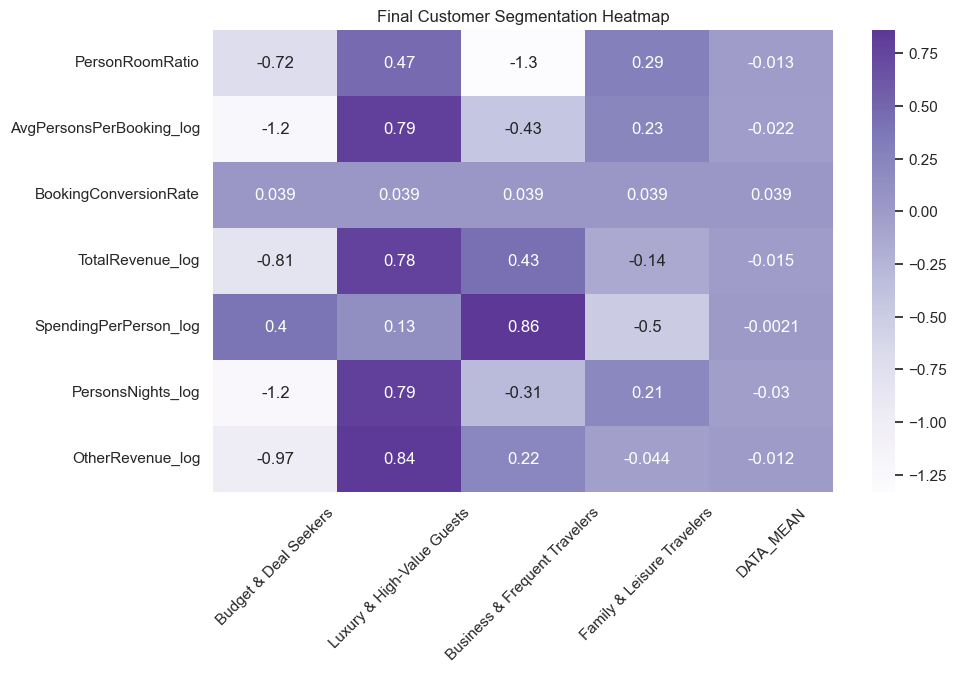

In [621]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compute cluster means
df_cluster_means = df[columns_to_use + ["merged_labels"]].groupby("merged_labels").mean().T

# Compute overall data mean
data_mean = pd.DataFrame(df[columns_to_use].mean().T, columns=["DATA_MEAN"])

# Merge cluster means with overall mean
df_all = pd.concat([df_cluster_means, data_mean], axis=1)

# Ensure the renaming is consistent with previous cluster naming
final_cluster_names = {
    0: "Budget & Deal Seekers",  
    1: "Luxury & High-Value Guests",  
    2: "Business & Frequent Travelers",
    3: "Family & Leisure Travelers"
}

# Apply renaming using mapped labels
df_all.rename(columns=final_cluster_names, inplace=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_all, annot=True, cmap="Purples", center=0)
plt.title("Final Customer Segmentation Heatmap")
plt.xticks(rotation=45)
plt.show()

0️⃣ Budget & Deal Seekers\
Includes: Balanced Travelers, Family & Group Travelers, Solo & Budget Travelers\
Characteristics:\
Price-sensitive, book via OTAs\
Frequent cancellations and longer lead times\
Prioritize affordability over convenience or luxury 

1️⃣ Luxury & High-Value Guests\
Includes: Family & Group Travelers, Solo & Budget Travelers\
Characteristics:\
High spending per stay (lodging + non-lodging)\
Prefer premium rooms, suites, and exclusive services\
Loyal, book through direct channels\

2️⃣ Business & Frequent Travelers\
Includes: Balanced Travelers (Corporate & Business Travelers, Luxury & High-Value Guests)\
Characteristics:\
Frequent, short stays\
High revenue per night but fewer additional expenses\
Prefer convenience, last-minute bookings\

3️⃣ Family & Leisure Travelers\
Includes: Family & Group Travelers, Solo & Budget Travelers (Corporate & Business Travelers)\
Characteristics:\
Travel for vacations or group stays\
Stay longer, book in advance\
Moderate spending, prioritize comfort & accessibility

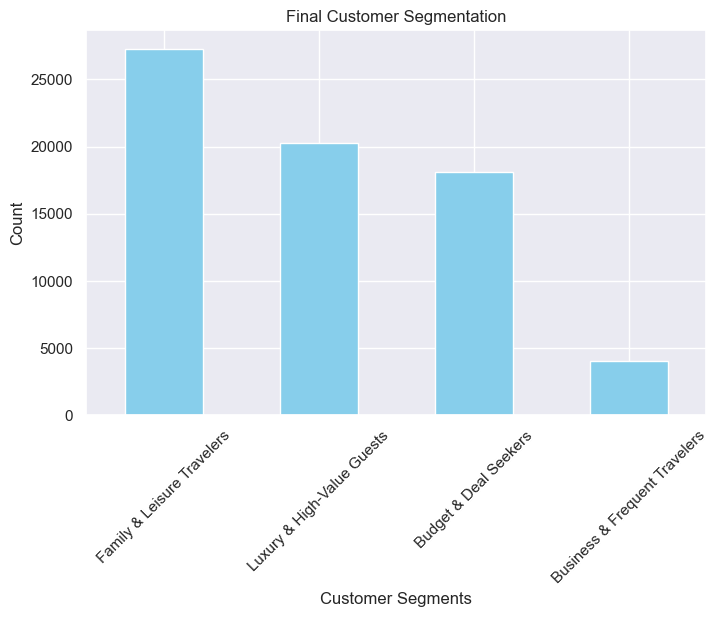

In [622]:
# Define the final cluster labels mapping
final_cluster_mapping = {
    0: "Budget & Deal Seekers",  
    1: "Luxury & High-Value Guests",  
    2: "Business & Frequent Travelers",
    3: "Family & Leisure Travelers"
}

# Apply the mapping to the merged labels
df['merged_labels'] = df['merged_labels'].map(final_cluster_mapping)

# Plot the cluster distribution
plt.figure(figsize=(8, 5))
df["merged_labels"].value_counts().plot(kind='bar', color='skyblue')

# Formatting
plt.xlabel('Customer Segments')
plt.ylabel('Count')
plt.title('Final Customer Segmentation')
plt.xticks(rotation=45)
plt.show()

In [623]:
def cluster_profiles(df, label_columns, figsize, 
                     cmap="tab10",
                     compare_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    
    if compare_titles == None:
        compare_titles = [""]*len(label_columns)
        
    fig, axes = plt.subplots(nrows=len(label_columns), 
                             ncols=2, 
                             figsize=figsize, 
                             constrained_layout=True,
                             squeeze=False)
    i = 0
    for ax, label, titl in zip(axes, label_columns, compare_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, 
                                            label, 
                                            color = sns.color_palette(cmap),
                                            ax=ax[0])



        sns.barplot(x=label, 
                    hue=label,
                    y="counts", 
                    data=counts, 
                    ax=ax[1], 
                    palette=sns.color_palette(cmap),
                    legend=False
                    )

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        if i == 0:
            cluster_labels = ["Balanced Travelers", "Family & Group Travelers", "Solo & Budget Travelers"]
        elif i == 1:
            cluster_labels = ["Budget & Deal-Seekers", "Corporate & Business Travelers", "Luxury & High-Value Guests"]
        else:
            cluster_labels = ["Luxury & High-Value Guests", "Business & Frequent Travelers", "Family & Leisure Travelers", "Budget & Deal Seekers"]
        i += 1
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), 
                              rotation=40,
                              ha='right'
                              )
        
        ax[0].legend(handles, cluster_labels,
                     loc='center left', bbox_to_anchor=(1, 0.5), title=label
                     ) # Adaptable to number of clusters
        
        ax[1].set_xticks([i for i in range(len(handles))])
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
        
        
    
    # plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profiling", fontsize=23)
    plt.show()

C:\Users\Elcano\AppData\Local\Temp\ipykernel_3180\4224293475.py:36: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(x=label,
C:\Users\Elcano\AppData\Local\Temp\ipykernel_3180\4224293475.py:36: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(x=label,
C:\Users\Elcano\AppData\Local\Temp\ipykernel_3180\4224293475.py:36: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(x=label,


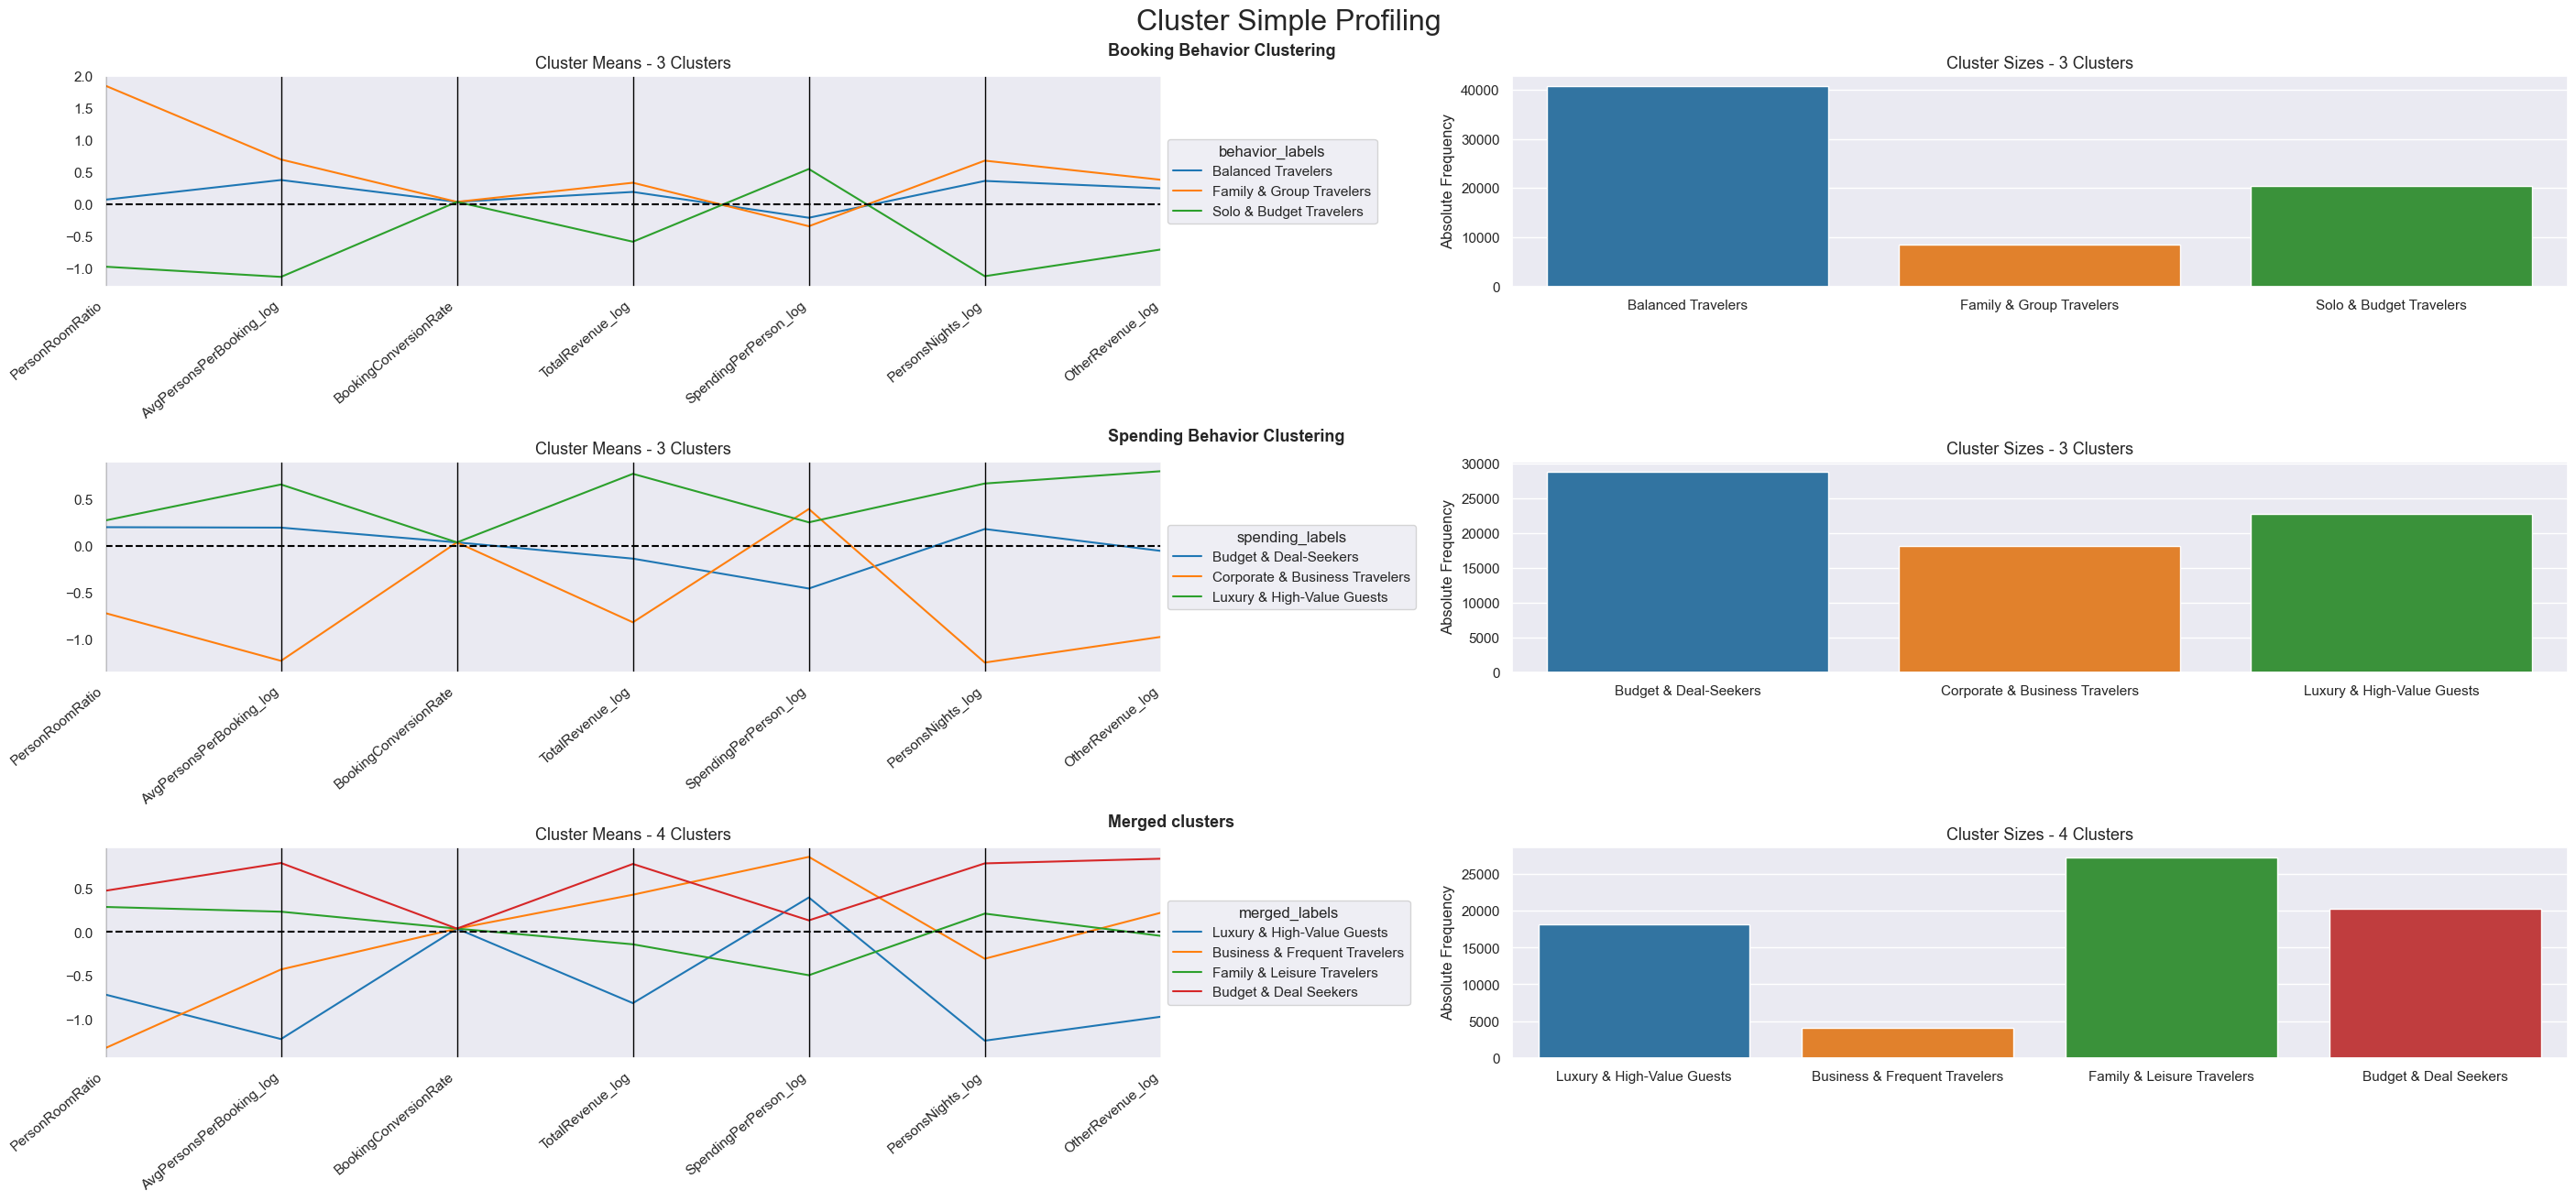

In [624]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df[columns_to_use + ['behavior_labels', 'spending_labels', 'merged_labels']], 
    label_columns = ['behavior_labels', 'spending_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compare_titles = ["Booking Behavior Clustering", "Spending Behavior Clustering", "Merged clusters"]
)

## Profiling with categorical features

In [625]:
new_cat_cols = [['Continent', 'AgeGroup', 
                 'LeadTimeSegment', 'FloorAsked',
                 'BathAsked', 'BedAsked',
                 'DistanceElevatorAsked',
                 'AccompanyingGuest', 
                 "MultipleRooms"]]

### Continent

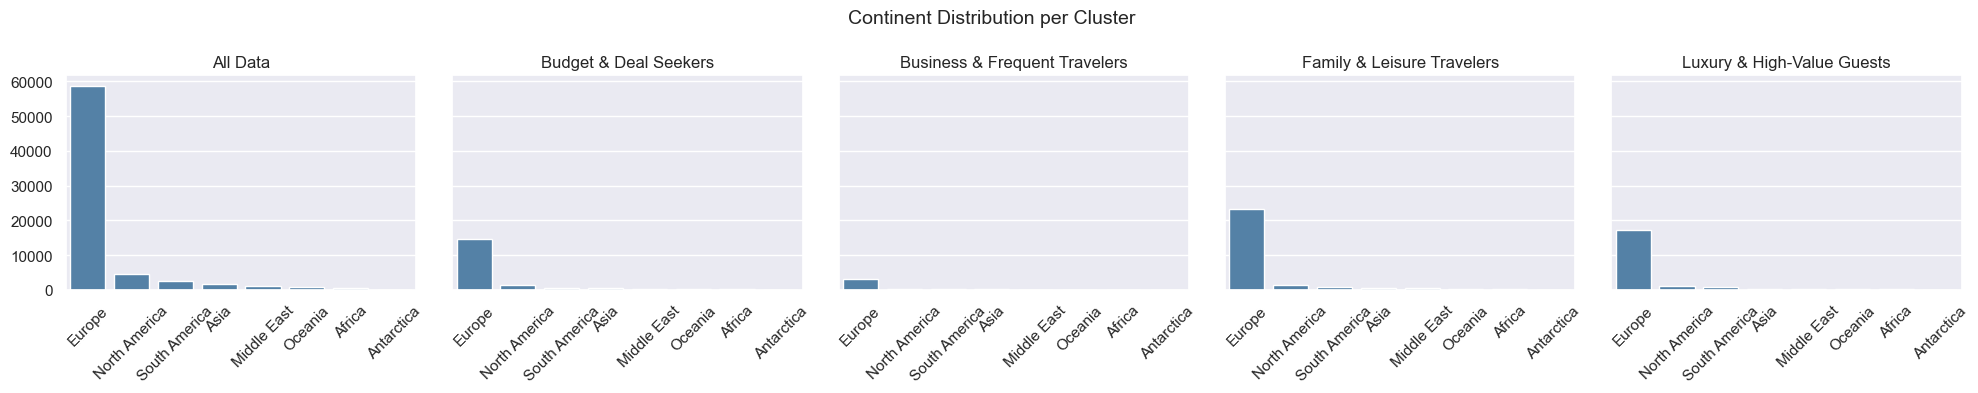

In [ ]:
# Count the number of occurrences of each continent per cluster
continent_distribution = df.groupby("merged_labels")["Continent"].value_counts().unstack().fillna(0)

# Sort continents based on total occurrences across all clusters
continent_order = df["Continent"].value_counts().index

# Create subplots
fig, axes = plt.subplots(1, len(continent_distribution.index) + 1, figsize=(20, 4), sharey=True)

# Plot for all data using the new ordering
sns.barplot(
    x=continent_order, 
    y=df["Continent"].value_counts()[continent_order].values, 
    ax=axes[0], color="steelblue"
)
axes[0].set_title("All Data")
axes[0].set_xlabel("")
axes[0].tick_params(axis='x', rotation=45)

# Plot each cluster separately using the sorted order
for idx, (cluster, data) in enumerate(continent_distribution.iterrows(), start=1):
    ordered_data = data.reindex(continent_order)  # Ensure same ordering as all data
    sns.barplot(x=ordered_data.index, y=ordered_data.values, ax=axes[idx], color="steelblue")
    axes[idx].set_title(cluster)
    axes[idx].set_xlabel("")
    axes[idx].tick_params(axis='x', rotation=45)

# Adjust layout
fig.suptitle("Continent Distribution per Cluster", fontsize=14)
plt.tight_layout()
plt.show()

### Age group

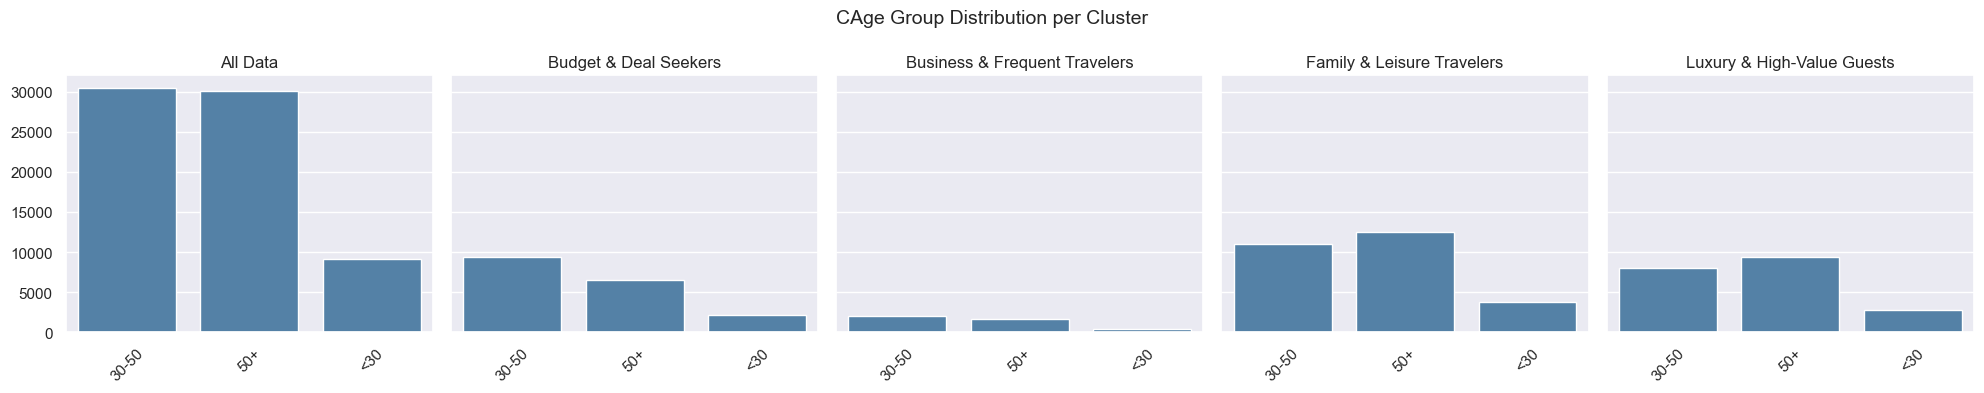

In [635]:
# Count the number of occurrences of each Age Group per cluster
Age_distribution = df.groupby("merged_labels")["AgeGroup"].value_counts().unstack().fillna(0)

# Sort Age Group based on total occurrences across all clusters
Age_group = df["AgeGroup"].value_counts().index

# Create subplots
fig, axes = plt.subplots(1, len(Age_distribution.index) + 1, figsize=(20, 4), sharey=True)

# Plot for all data using the new ordering
sns.barplot(
    x=Age_group, 
    y=df["AgeGroup"].value_counts()[Age_group].values, 
    ax=axes[0], color="steelblue"
)
axes[0].set_title("All Data")
axes[0].set_xlabel("")
axes[0].tick_params(axis='x', rotation=45)

# Plot each cluster separately using the sorted order
for idx, (cluster, data) in enumerate(Age_distribution.iterrows(), start=1):
    ordered_data = data.reindex(Age_group)  # Ensure same ordering as all data
    sns.barplot(x=ordered_data.index, y=ordered_data.values, ax=axes[idx], color="steelblue")
    axes[idx].set_title(cluster)
    axes[idx].set_xlabel("")
    axes[idx].tick_params(axis='x', rotation=45)

# Adjust layout
fig.suptitle("CAge Group Distribution per Cluster", fontsize=14)
plt.tight_layout()
plt.show()

### Lead Time Segment

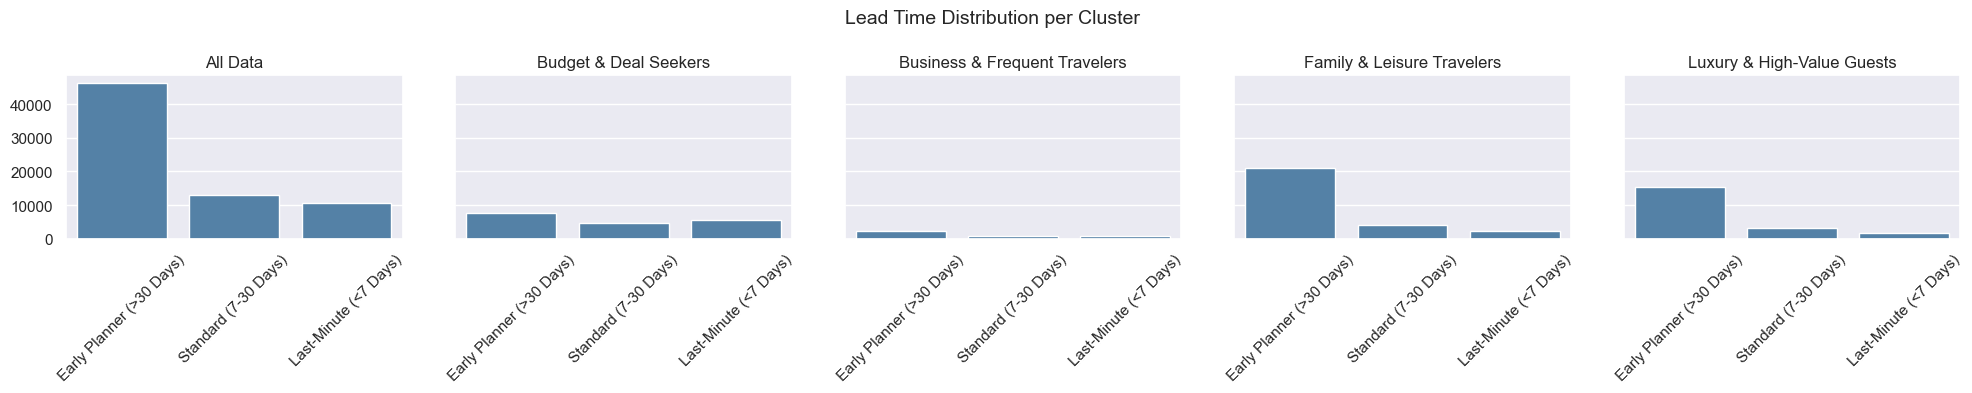

In [637]:
# Count the number of occurrences of each continent per cluster
LeadTime_distribution = df.groupby("merged_labels")["LeadTimeSegment"].value_counts().unstack().fillna(0)

# Sort continents based on total occurrences across all clusters
LeadTime_Segment = df["LeadTimeSegment"].value_counts().index

# Create subplots
fig, axes = plt.subplots(1, len(LeadTime_distribution.index) + 1, figsize=(20, 4), sharey=True)

# Plot for all data using the new ordering
sns.barplot(
    x=LeadTime_Segment, 
    y=df["LeadTimeSegment"].value_counts()[LeadTime_Segment].values, 
    ax=axes[0], color="steelblue"
)
axes[0].set_title("All Data")
axes[0].set_xlabel("")
axes[0].tick_params(axis='x', rotation=45)

# Plot each cluster separately using the sorted order
for idx, (cluster, data) in enumerate(LeadTime_distribution.iterrows(), start=1):
    ordered_data = data.reindex(LeadTime_Segment)  # Ensure same ordering as all data
    sns.barplot(x=ordered_data.index, y=ordered_data.values, ax=axes[idx], color="steelblue")
    axes[idx].set_title(cluster)
    axes[idx].set_xlabel("")
    axes[idx].tick_params(axis='x', rotation=45)

# Adjust layout
fig.suptitle("Lead Time Distribution per Cluster", fontsize=14)
plt.tight_layout()
plt.show()

### Floor asked

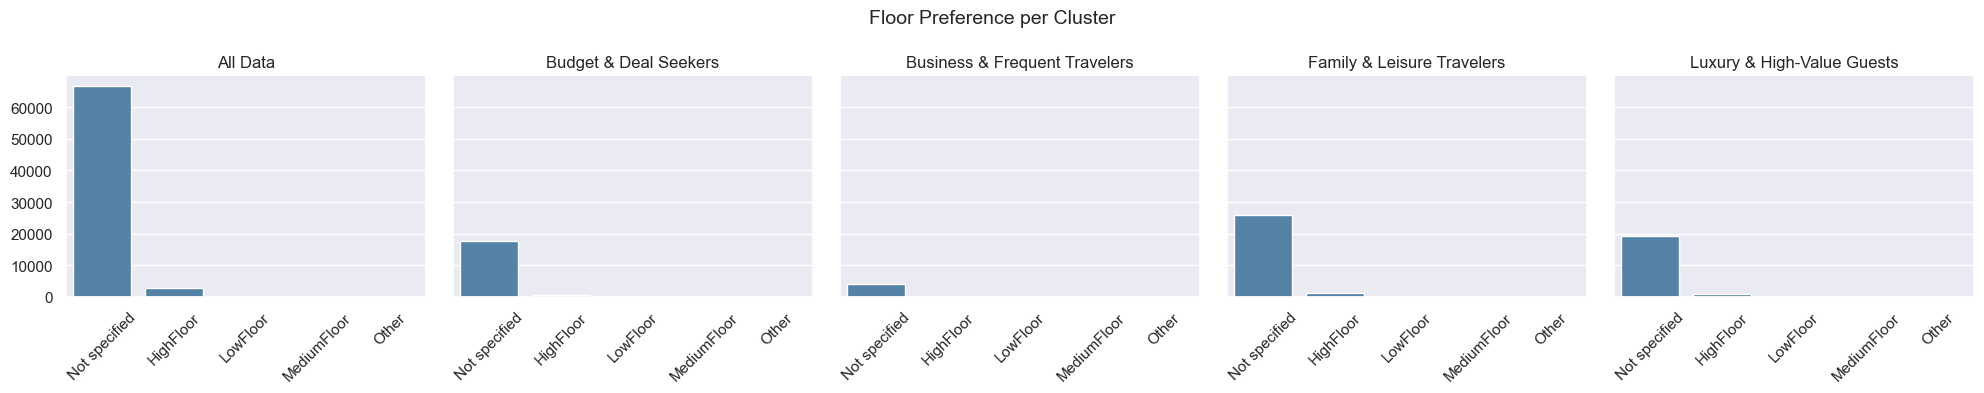

In [638]:
# Count the number of occurrences of each continent per cluster
Floor_distribution = df.groupby("merged_labels")["FloorAsked"].value_counts().unstack().fillna(0)

# Sort continents based on total occurrences across all clusters
Floor_order = df["FloorAsked"].value_counts().index

# Create subplots
fig, axes = plt.subplots(1, len(Floor_distribution.index) + 1, figsize=(20, 4), sharey=True)

# Plot for all data using the new ordering
sns.barplot(
    x=Floor_order, 
    y=df["FloorAsked"].value_counts()[Floor_order].values, 
    ax=axes[0], color="steelblue"
)
axes[0].set_title("All Data")
axes[0].set_xlabel("")
axes[0].tick_params(axis='x', rotation=45)

# Plot each cluster separately using the sorted order
for idx, (cluster, data) in enumerate(Floor_distribution.iterrows(), start=1):
    ordered_data = data.reindex(Floor_order)  # Ensure same ordering as all data
    sns.barplot(x=ordered_data.index, y=ordered_data.values, ax=axes[idx], color="steelblue")
    axes[idx].set_title(cluster)
    axes[idx].set_xlabel("")
    axes[idx].tick_params(axis='x', rotation=45)

# Adjust layout
fig.suptitle("Floor Preference per Cluster", fontsize=14)
plt.tight_layout()
plt.show()

### BathAsked

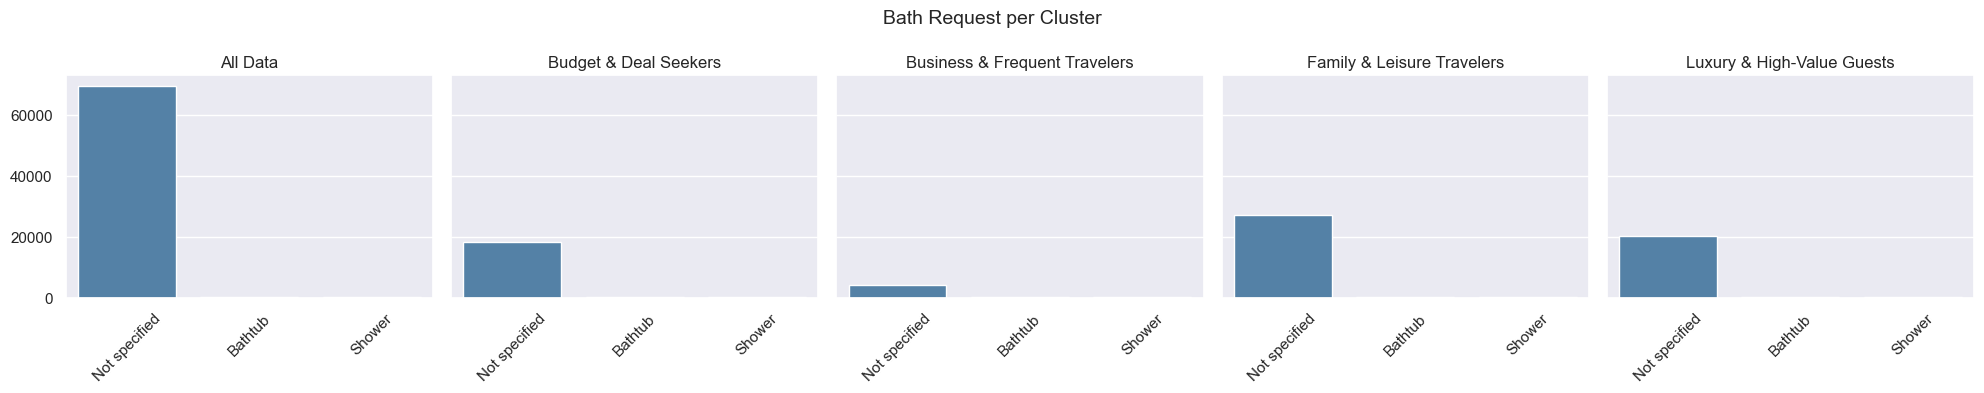

In [640]:
# Count the number of occurrences of each continent per cluster
Bath_distribution = df.groupby("merged_labels")["BathAsked"].value_counts().unstack().fillna(0)

# Sort continents based on total occurrences across all clusters
Bath_request = df["BathAsked"].value_counts().index

# Create subplots
fig, axes = plt.subplots(1, len(Bath_distribution.index) + 1, figsize=(20, 4), sharey=True)

# Plot for all data using the new ordering
sns.barplot(
    x=Bath_request, 
    y=df["BathAsked"].value_counts()[Bath_request].values, 
    ax=axes[0], color="steelblue"
)
axes[0].set_title("All Data")
axes[0].set_xlabel("")
axes[0].tick_params(axis='x', rotation=45)

# Plot each cluster separately using the sorted order
for idx, (cluster, data) in enumerate(Bath_distribution.iterrows(), start=1):
    ordered_data = data.reindex(Bath_request)  # Ensure same ordering as all data
    sns.barplot(x=ordered_data.index, y=ordered_data.values, ax=axes[idx], color="steelblue")
    axes[idx].set_title(cluster)
    axes[idx].set_xlabel("")
    axes[idx].tick_params(axis='x', rotation=45)

# Adjust layout
fig.suptitle("Bath Request per Cluster", fontsize=14)
plt.tight_layout()
plt.show()

### BedAsked

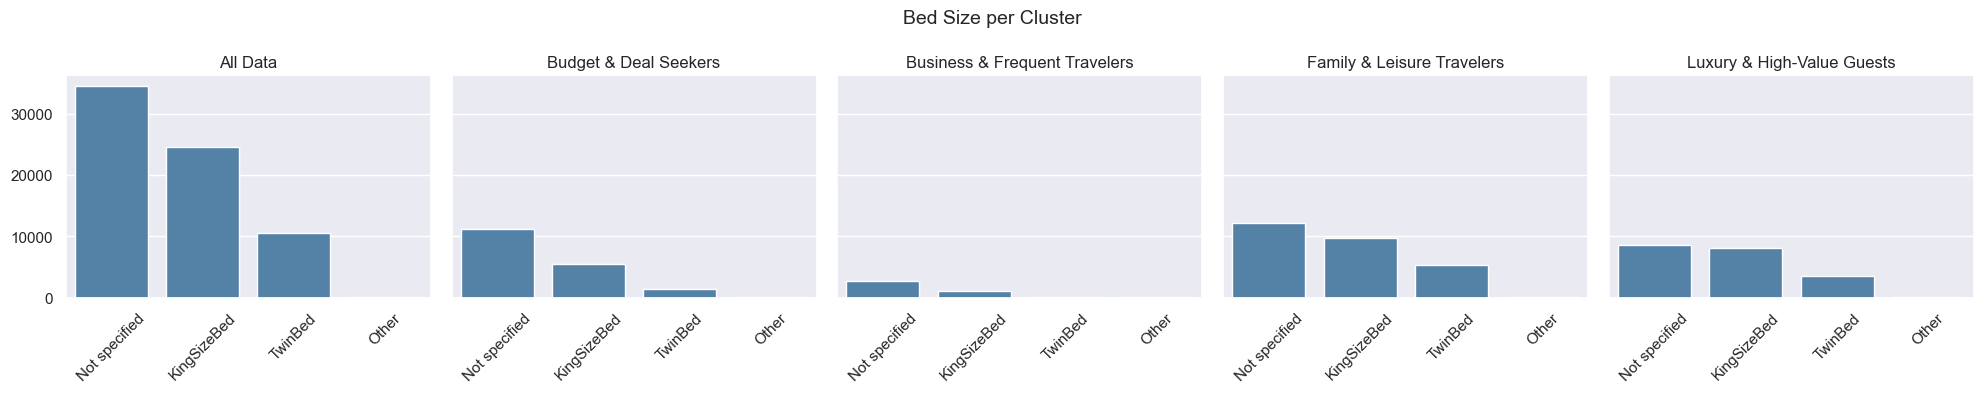

In [639]:
# Count the number of occurrences of each continent per cluster
Bed_distribution = df.groupby("merged_labels")["BedAsked"].value_counts().unstack().fillna(0)

# Sort continents based on total occurrences across all clusters
Bed_size = df["BedAsked"].value_counts().index

# Create subplots
fig, axes = plt.subplots(1, len(Bed_distribution.index) + 1, figsize=(20, 4), sharey=True)

# Plot for all data using the new ordering
sns.barplot(
    x=Bed_size, 
    y=df["BedAsked"].value_counts()[Bed_size].values, 
    ax=axes[0], color="steelblue"
)
axes[0].set_title("All Data")
axes[0].set_xlabel("")
axes[0].tick_params(axis='x', rotation=45)

# Plot each cluster separately using the sorted order
for idx, (cluster, data) in enumerate(Bed_distribution.iterrows(), start=1):
    ordered_data = data.reindex(Bed_size)  # Ensure same ordering as all data
    sns.barplot(x=ordered_data.index, y=ordered_data.values, ax=axes[idx], color="steelblue")
    axes[idx].set_title(cluster)
    axes[idx].set_xlabel("")
    axes[idx].tick_params(axis='x', rotation=45)

# Adjust layout
fig.suptitle("Bed Size per Cluster", fontsize=14)
plt.tight_layout()
plt.show()

### Accompaying

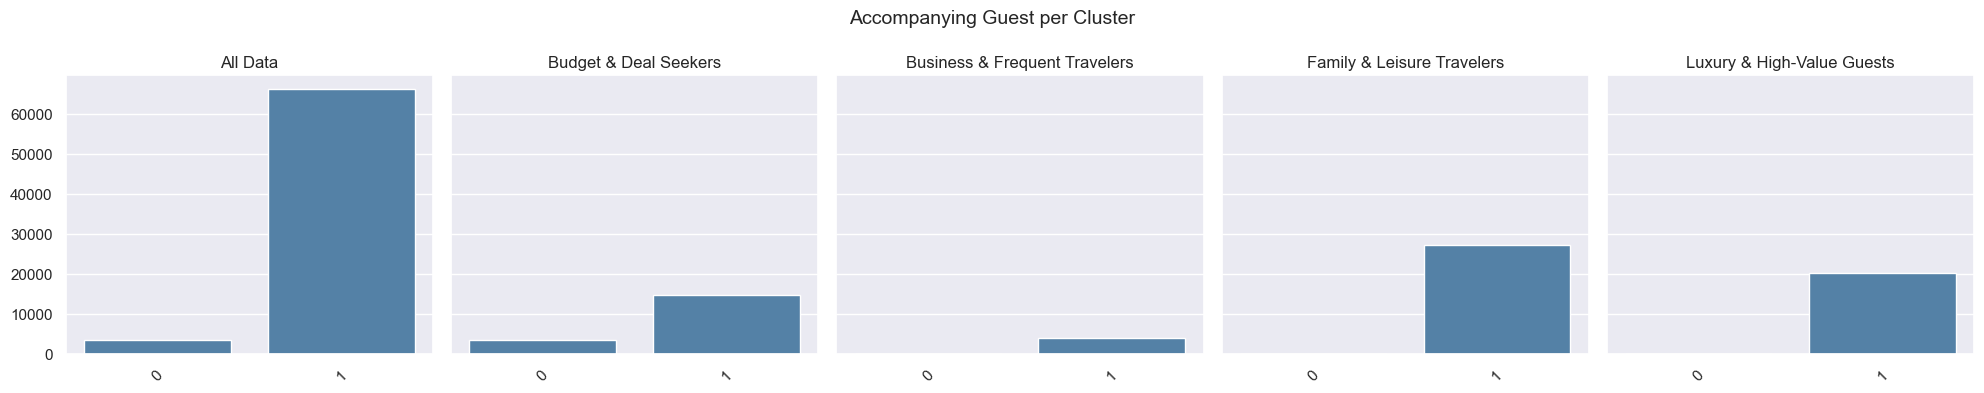

In [641]:
# Count the number of occurrences of each continent per cluster
Accompanying_Guest = df.groupby("merged_labels")["AccompanyingGuest"].value_counts().unstack().fillna(0)

# Sort continents based on total occurrences across all clusters
Guest = df["AccompanyingGuest"].value_counts().index

# Create subplots
fig, axes = plt.subplots(1, len(Accompanying_Guest.index) + 1, figsize=(20, 4), sharey=True)

# Plot for all data using the new ordering
sns.barplot(
    x=Guest, 
    y=df["AccompanyingGuest"].value_counts()[Guest].values, 
    ax=axes[0], color="steelblue"
)
axes[0].set_title("All Data")
axes[0].set_xlabel("")
axes[0].tick_params(axis='x', rotation=45)

# Plot each cluster separately using the sorted order
for idx, (cluster, data) in enumerate(Accompanying_Guest.iterrows(), start=1):
    ordered_data = data.reindex(Guest)  # Ensure same ordering as all data
    sns.barplot(x=ordered_data.index, y=ordered_data.values, ax=axes[idx], color="steelblue")
    axes[idx].set_title(cluster)
    axes[idx].set_xlabel("")
    axes[idx].tick_params(axis='x', rotation=45)

# Adjust layout
fig.suptitle("Accompanying Guest per Cluster", fontsize=14)
plt.tight_layout()
plt.show()